#### Import libraries

In [446]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns

## Analysis Functions

#### Detect outliers

In [447]:
def detect_outliers(linear_model):
    influence = linear_model.get_influence()
    n = int(linear_model.nobs)
    cooks_d = influence.cooks_distance[0]
    outliers = np.where(cooks_d > 4 / n)[0]
    return outliers, cooks_d

#### Plot outliers

In [448]:

def _plot_cooks(ax, cooks_d, outliers):
    n = len(cooks_d)
    x = np.arange(n)

    sns.barplot(x=x, y=cooks_d, ax=ax)
    ax.plot(x, np.full(n, 4 / n), linestyle="dotted", linewidth=1, color="red")

    for o in outliers:
        ax.text(o, cooks_d[o] + 0.005, str(o),
                ha="center", va="bottom", fontsize=8)

    ax.set_title("Cook’s Distance")
    ax.set_xlabel("Observation index")
    ax.set_ylabel("Cook’s distance")
    ax.set_xticks(range(0, n, max(1, n // 5)))

def outlier_single_plot(cooks_d, outliers):
    _, axes = plt.subplots(1, 2, figsize=(18, 5), sharey=True)

    _plot_cooks(axes[0], cooks_d, outliers)
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

def outliers_double_plot(cooks_d_1, cooks_d_2, outliers_1, outliers_2):
    _, axes = plt.subplots(1, 2, figsize=(18, 5), sharey=True)

    _plot_cooks(axes[0], cooks_d_1, outliers_1)
    _plot_cooks(axes[1], cooks_d_2, outliers_2)

    plt.tight_layout()
    plt.show()

#### Residual vs Fitted plots for OLS model

In [449]:

def _plot_res_vs_fitted_ols(ax, model, title="OLS Residuals vs Fitted"):
    fitted = model.fittedvalues
    resid = model.resid

    sns.residplot(
        x=fitted,
        y=resid,
        lowess=True,
        line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8},
        ax=ax
    )
    abs_resid = np.abs(resid)
    top_idx = np.argsort(abs_resid)[-5:]

    for i in top_idx:
        ax.annotate(
            str(i),
            xy=(fitted.iloc[i], resid.iloc[i]),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=9,
            color="C3"
        )
    ax.axhline(0, color='black', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel("Fitted Values")
    ax.set_ylabel("Residuals")
    ax.grid(True, alpha=0.3)

def res_vs_fitted_ols_single(model):
    _, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    _plot_res_vs_fitted_ols(axes[0], model)
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

def res_vs_fitted_ols_double(model1, model2, titles=("Model 1", "Model 2")):
    _, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    _plot_res_vs_fitted_ols(axes[0], model1, f"OLS Residuals vs Fitted – {titles[0]}")
    _plot_res_vs_fitted_ols(axes[1], model2, f"OLS Residuals vs Fitted – {titles[1]}")

    plt.tight_layout()
    plt.show()

#### Residual vs Fitted plots for GLM model

In [450]:

def _plot_res_vs_fitted_glm(ax, model, title="GLM Residuals vs Fitted"):
    fitted = model.mu
    resid = model.resid_deviance
    sns.residplot(
        x=fitted,
        y=resid,
        lowess=True,
        line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8},
        ax=ax
    )
    ax.axhline(0, color='black', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel("Fitted Values")
    ax.set_ylabel("Residuals")
    ax.grid(True, alpha=0.3)

def res_vs_fitted_glm_single(model):
    _, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    _plot_res_vs_fitted_glm(axes[0], model)
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

def res_vs_fitted_glm_double(model1, model2, titles=("Model 1", "Model 2")):
    _, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    _plot_res_vs_fitted_glm(axes[0], model1, f"GLM Residuals vs Fitted – {titles[0]}")
    _plot_res_vs_fitted_glm(axes[1], model2, f"GLM Residuals vs Fitted – {titles[1]}")

    plt.tight_layout()
    plt.show()

#### Component-Component plus Residual (CCPR) = Partial Residual Plot

In [451]:
def ccpr_plot(linear_model):
    fig = plt.figure(figsize=(15, 10))
    sm.graphics.plot_ccpr_grid(linear_model, fig=fig)
    plt.show()

#### Correlation matrix plot

In [452]:
def _plot_corr_mtx(ax, corr_matrix, title="Correlation Matrix"):
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap="RdBu",
        center=0,
        fmt=".2f",
        ax=ax
    )
    ax.set_title(title)

def corr_mtx_single(corr_matrix, title="Correlation Matrix"):
    _, axes = plt.subplots(1, 2, figsize=(22, 10))
    
    _plot_corr_mtx(axes[0], corr_matrix, title)
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

def corr_mtx_double(
    corr_matrix_1,
    corr_matrix_2,
    titles=("Correlation Matrix 1", "Correlation Matrix 2")
):
    _, axes = plt.subplots(1, 2, figsize=(22, 10), sharey=True)

    _plot_corr_mtx(axes[0], corr_matrix_1, titles[0])
    _plot_corr_mtx(axes[1], corr_matrix_2, titles[1])

    plt.tight_layout()
    plt.show()


#### VIF factor calculation

In [453]:
def vif_calcul(data, features):
    X_vif = data[features].copy()
    X_vif['intercept'] = 1
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
    return  vif_data

#### Stepwise feature selection

In [454]:
def stepwise_feature_selection(df, list_of_features, threshold=5.0):
    """
    Automatically drops the variable with the highest VIF 
    until all remaining variables are below the threshold.
    """
    while True:

        X = df[list_of_features].copy()
        X['intercept'] = 1
        
        vif = pd.DataFrame()
        vif["feature"] = X.columns
        vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
        vif = vif[vif['feature'] != 'intercept'].sort_values('VIF', ascending=False)
        
        max_vif = vif.iloc[0]['VIF']
        if max_vif > threshold:
            if vif.iloc[0]['feature'] == 'airbnb_economy_density':
                target = vif.iloc[1]['feature']
            else:
                target = vif.iloc[0]['feature']
                
            print(f"Dropping {target} with VIF {max_vif:.2f}")
            list_of_features.remove(target)
        else:
            break
            
    return list_of_features, vif

#### Data standardization (scale)

In [455]:
from sklearn.preprocessing import StandardScaler

# run before advanced feature selection methods (ridge, lasso, PCA)
def scale_data(data, features):
    X = data[features]
    y = np.log1p(data['crime_density'])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y

#### Ridge

In [456]:
from sklearn.linear_model import RidgeCV

def ridge_regression(X_scaled, y, features):
    ridge_model_econ = RidgeCV(alphas=np.logspace(-6, 6, 13))
    ridge_model_econ.fit(X_scaled, y)
    ridge_coefs = pd.Series(ridge_model_econ.coef_, index=features).sort_values(ascending=False)
    print("Best Alpha for Ridge:", ridge_model_econ.alpha_)
    print("Ridge Coefficients:\n", ridge_coefs)

#### Lasso

In [457]:
from sklearn.linear_model import LassoCV

def lasso_regression(X_scaled, y, features):
    lasso_model_econ = LassoCV(alphas=None, cv=10, max_iter=10000)
    lasso_model_econ.fit(X_scaled, y)
    lasso_coefs_econ = pd.Series(lasso_model_econ.coef_, index=features).sort_values(ascending=False)
    print("Best Alpha for Lasso:", lasso_model_econ.alpha_)
    print("Lasso Coefficients:\n", lasso_coefs_econ)

#### PCA

##### Scree plot

In [458]:
def scree_plot(pca):
    exp_var_cum = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(exp_var_cum) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='Individual variance')
    plt.step(range(1, len(exp_var_cum) + 1), exp_var_cum, where='mid', label='Cumulative variance', color='red')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.title('Scree Plot: Variance Explained by Components')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)

##### PCA loadings

In [459]:
def pca_loadings(pca, features):
    loadings = pd.DataFrame(
        pca.components_.T, 
        columns=[f'PC{i+1}' for i in range(len(features))], 
        index=features
    )
    plt.figure(figsize=(10, 8))
    sns.heatmap(loadings.iloc[:, :3], annot=True, cmap='RdBu', center=0)
    plt.title('PCA Loadings (What each component represents)')

## Dataset

#### Load dataset

In [460]:
df = pd.read_csv("../data/final_dataset_mest.csv")

#### Unify variables

For more precise modeling, all variables were standardized to a common spatial unit (km²).

In [461]:
# unifying calculations (per km^2)
df['crime_density'] = df['crime_total'] / df['area_km2']
df['crime_attractor_density'] = (df['poi_pub'] + df['poi_nightclub'] + df['poi_bar']) / df['area_km2']
df['crime_generator_density'] = (df['poi_cafe'] + df['poi_museum'] + df['poi_attraction']) / df['area_km2']
df['tourist_density'] = df['nights_non_residents'] / df['area_km2']
df['foreigner_density'] = df['foreigners'] / df['area_km2']
df['university_density'] = df['people_university'] / df['area_km2']
df['airbnb_economy_density'] = df['airbnb_economy'] / df['area_km2']
df['crime_Burglary_density'] = df['crime_Burglary'] / df['area_km2']
df['crime_Disorder_density'] = df['crime_Disorder'] / df['area_km2']
df['crime_Theft_density'] = df['crime_Theft'] / df['area_km2']
df['crime_Violent_density'] = df['crime_Violent'] / df['area_km2']
df['crime_Other_density'] = df['crime_Other'] / df['area_km2']

# handle NaN values
df = df.fillna(0.0)

# Economy vs Luxury Airbnb Density

#### Construct Simple OLS Models

1. we predict crime_density in each Prague district
2. separate so called crime attractors (bars, pubs, nightclubs) and crime generators (cafes, museums, atractions) into two separated models
3. remove variables that are most likely multicolinear with crime_density (crime_total, crime_Burglary, crime_Disorder, crime_Other, crime_Theft,...)

In [462]:
lm_crime_economy = smf.ols('crime_density ~ dist_center_km + airbnb_economy_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=df).fit()

lm_crime_luxury = smf.ols('crime_density ~ dist_center_km + airbnb_luxury_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=df).fit()

## Outliers

#### Analysing Outliers

In [463]:
# outliers detection using Cook's distance
outliers_economy, cooks_d_economy = detect_outliers(lm_crime_economy)
print(f"Outliers of economy model: {outliers_economy}")

outliers_luxury, cooks_d_luxury = detect_outliers(lm_crime_luxury)
print(f"Outliers of luxury model: {outliers_luxury}")

Outliers of economy model: [ 0  2  8 11 15 19 21 46 56]
Outliers of luxury model: [ 0  2  4  8 11 15 19 21 46 56]


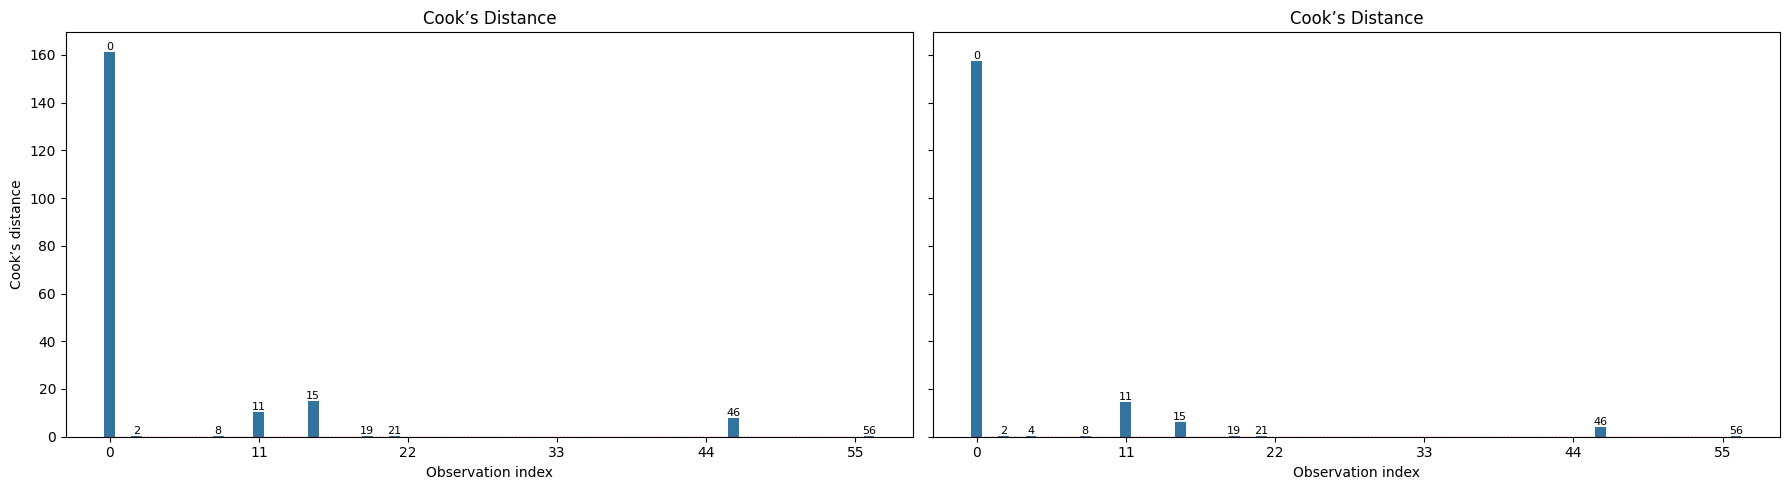

In [464]:
outliers_double_plot(cooks_d_economy, cooks_d_luxury, outliers_economy, outliers_luxury)

Between identified outliers are Prague districts _Praha 1_ (0) and _Praha 2_ (11), which are districts with the biggest Airbnb density and influence the model the most. Thus, we decided not to remove these.

In [465]:
X = df.drop([2, 8, 21, 46, 56])

Refit the model without outliers

In [466]:
lm_crime_economy = smf.ols('crime_density ~ dist_center_km + airbnb_economy_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=X).fit()

lm_crime_luxury = smf.ols('crime_density ~ dist_center_km + airbnb_luxury_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=X).fit()

## Linearity and Homoscedasticity

#### Analysis of linearity and homoscedasticity quality

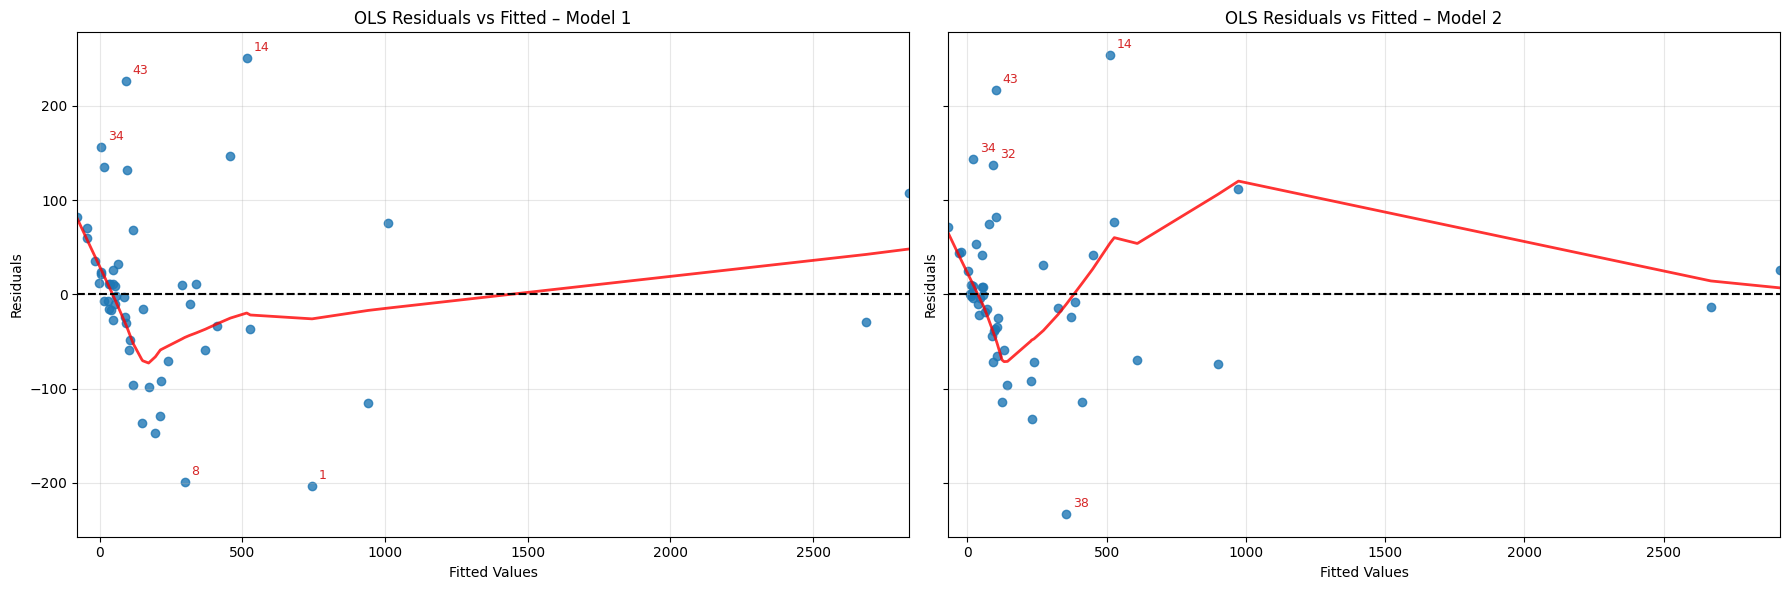

In [467]:
res_vs_fitted_ols_double(lm_crime_economy, lm_crime_luxury)

Residuals vs fitted plot shows significant heteroscedasticity and data is not linear. It is necessary to switch from simple OLS model to GLM model for futher data manupulation. In the next step we find proper feature transformation to reduce non-linearity and  heteroscedasticity.

#### More feature diagnostics

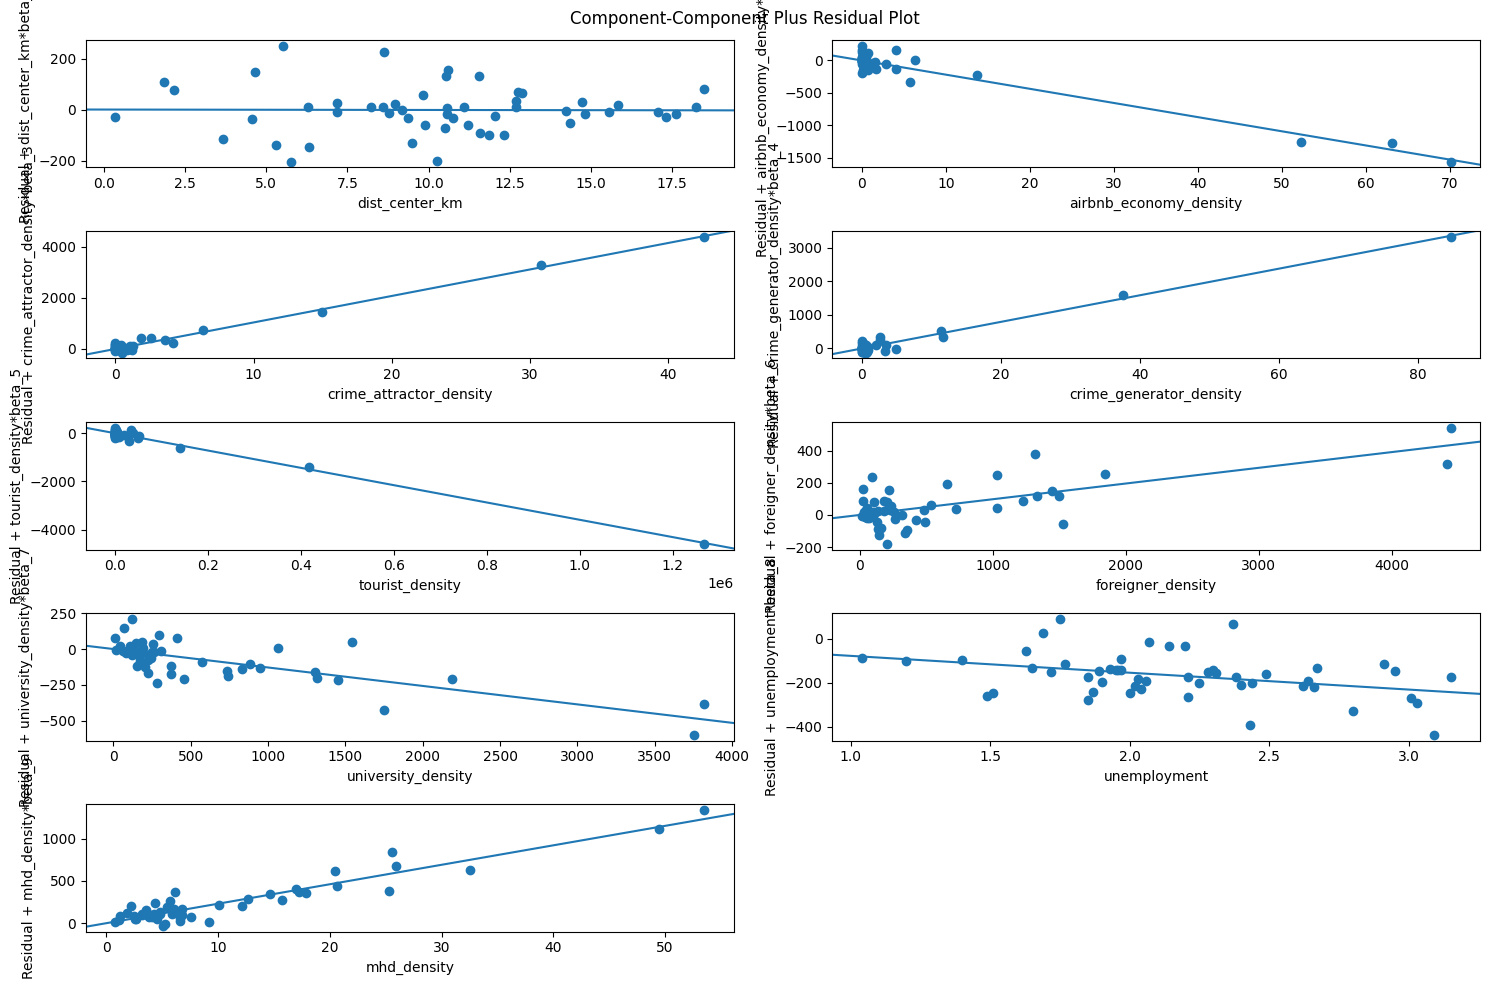

In [468]:
ccpr_plot(lm_crime_economy)

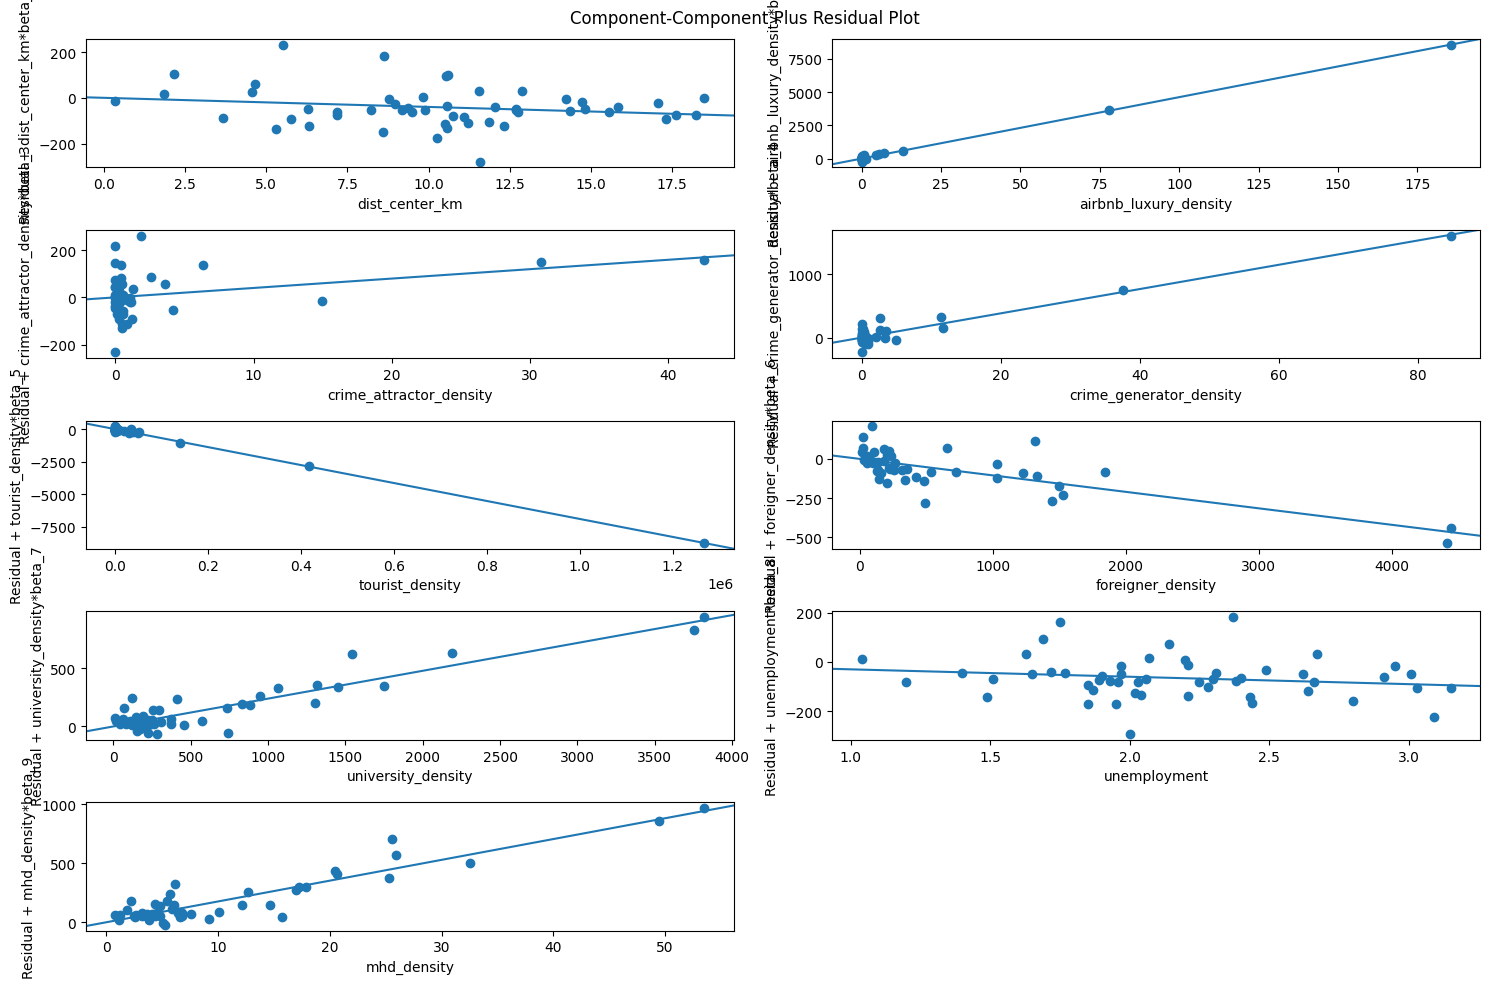

In [469]:
ccpr_plot(lm_crime_luxury)

In [470]:
formula = ('np.log1p(crime_density) ~ dist_center_km + I(dist_center_km**2) + '
           'np.log1p(airbnb_economy_density) + np.log1p(tourist_density) + '
           'np.log1p(crime_attractor_density) + np.log1p(crime_generator_density) + '
           'np.log1p(foreigner_density) + np.log1p(university_density) + unemployment + '
           'np.log1p(mhd_density)')

glm_log_economy = smf.glm(
    formula=formula, 
    data=X, 
    family=sm.families.Gaussian()
).fit()

print(glm_log_economy.summary())
glm_log_economy.aic


                    Generalized Linear Model Regression Results                    
Dep. Variable:     np.log1p(crime_density)   No. Observations:                   52
Model:                                 GLM   Df Residuals:                       41
Model Family:                     Gaussian   Df Model:                           10
Link Function:                    Identity   Scale:                         0.43369
Method:                               IRLS   Log-Likelihood:                -45.884
Date:                     Wed, 31 Dec 2025   Deviance:                       17.781
Time:                             12:43:30   Pearson chi2:                     17.8
No. Iterations:                          3   Pseudo R-squ. (CS):             0.9822
Covariance Type:                 nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

np.float64(113.76851233838252)

In [471]:
formula = ('np.log1p(crime_density) ~ dist_center_km + I(dist_center_km**2) + '
           'np.log1p(airbnb_luxury_density) + np.log1p(tourist_density) + '
           'np.log1p(crime_attractor_density) + np.log1p(crime_generator_density) + '
           'np.log1p(foreigner_density) + np.log1p(university_density) + unemployment + '
           'np.log1p(mhd_density)')

glm_log_luxury = smf.glm(
    formula=formula, 
    data=X, 
    family=sm.families.Gaussian()
).fit()

print(glm_log_luxury.summary())
glm_log_luxury.aic

                    Generalized Linear Model Regression Results                    
Dep. Variable:     np.log1p(crime_density)   No. Observations:                   52
Model:                                 GLM   Df Residuals:                       41
Model Family:                     Gaussian   Df Model:                           10
Link Function:                    Identity   Scale:                         0.40409
Method:                               IRLS   Log-Likelihood:                -44.046
Date:                     Wed, 31 Dec 2025   Deviance:                       16.568
Time:                             12:43:30   Pearson chi2:                     16.6
No. Iterations:                          3   Pseudo R-squ. (CS):             0.9874
Covariance Type:                 nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

np.float64(110.0923589403494)

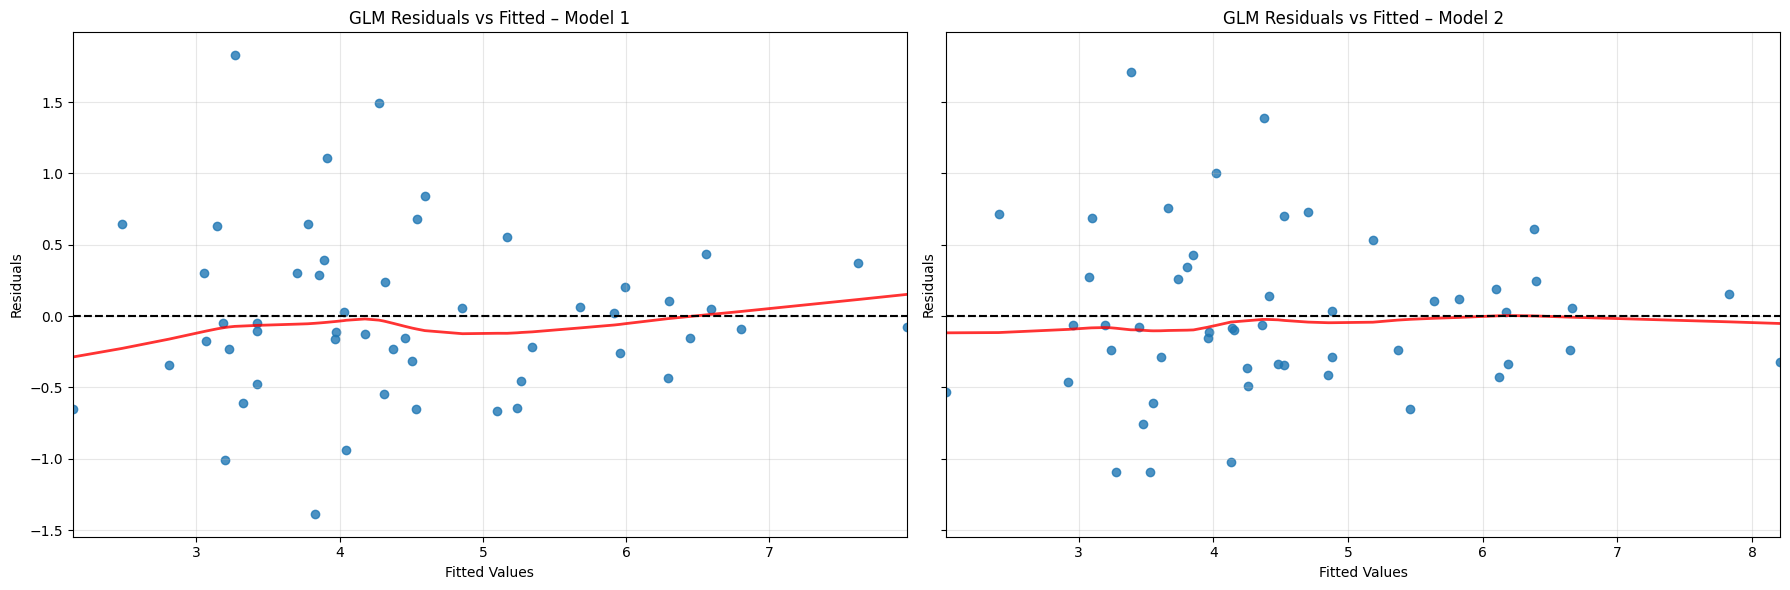

In [472]:
res_vs_fitted_glm_double(glm_log_economy, glm_log_luxury)

Current transformation is "good enough" structurally. The remaining "wiggles" in the red line are likely noise, not a structural trend that a Spline would fix better than the current setup.

In [473]:
# Homoscedasticity tests

_, pval, __, ___ = het_breuschpagan(glm_log_economy.resid_deviance, glm_log_economy.model.exog)
print(f"Breusch-Pagan p-value - economy airbnb: {pval}")

_, pval, __, ___ = het_breuschpagan(glm_log_luxury.resid_deviance, glm_log_luxury.model.exog)
print(f"Breusch-Pagan p-value - luxury airbnb: {pval}")

Breusch-Pagan p-value - economy airbnb: 0.33789685751468235
Breusch-Pagan p-value - luxury airbnb: 0.38798775138248925


The Breusch–Pagan test shows marginal evidence of heteroscedasticity. While slightly below conventional thresholds, the residuals do not strongly violate the homoscedasticity assumption, so the model can be considered acceptable for further analysis.

## Multicollinearity and Feature Selection

#### Correlation Matrix

In [474]:
features_economy = ['dist_center_km', 'airbnb_economy_density', 'tourist_density', 
            'crime_attractor_density', 'crime_generator_density', 
            'foreigner_density', 'university_density', 'unemployment', 'mhd_density']

corr_matrix_economy = X[features_economy].corr()

features_luxury = ['dist_center_km', 'airbnb_luxury_density', 'tourist_density', 
            'crime_attractor_density', 'crime_generator_density', 
            'foreigner_density', 'university_density', 'unemployment', 'mhd_density']

corr_matrix_luxury = X[features_luxury].corr()

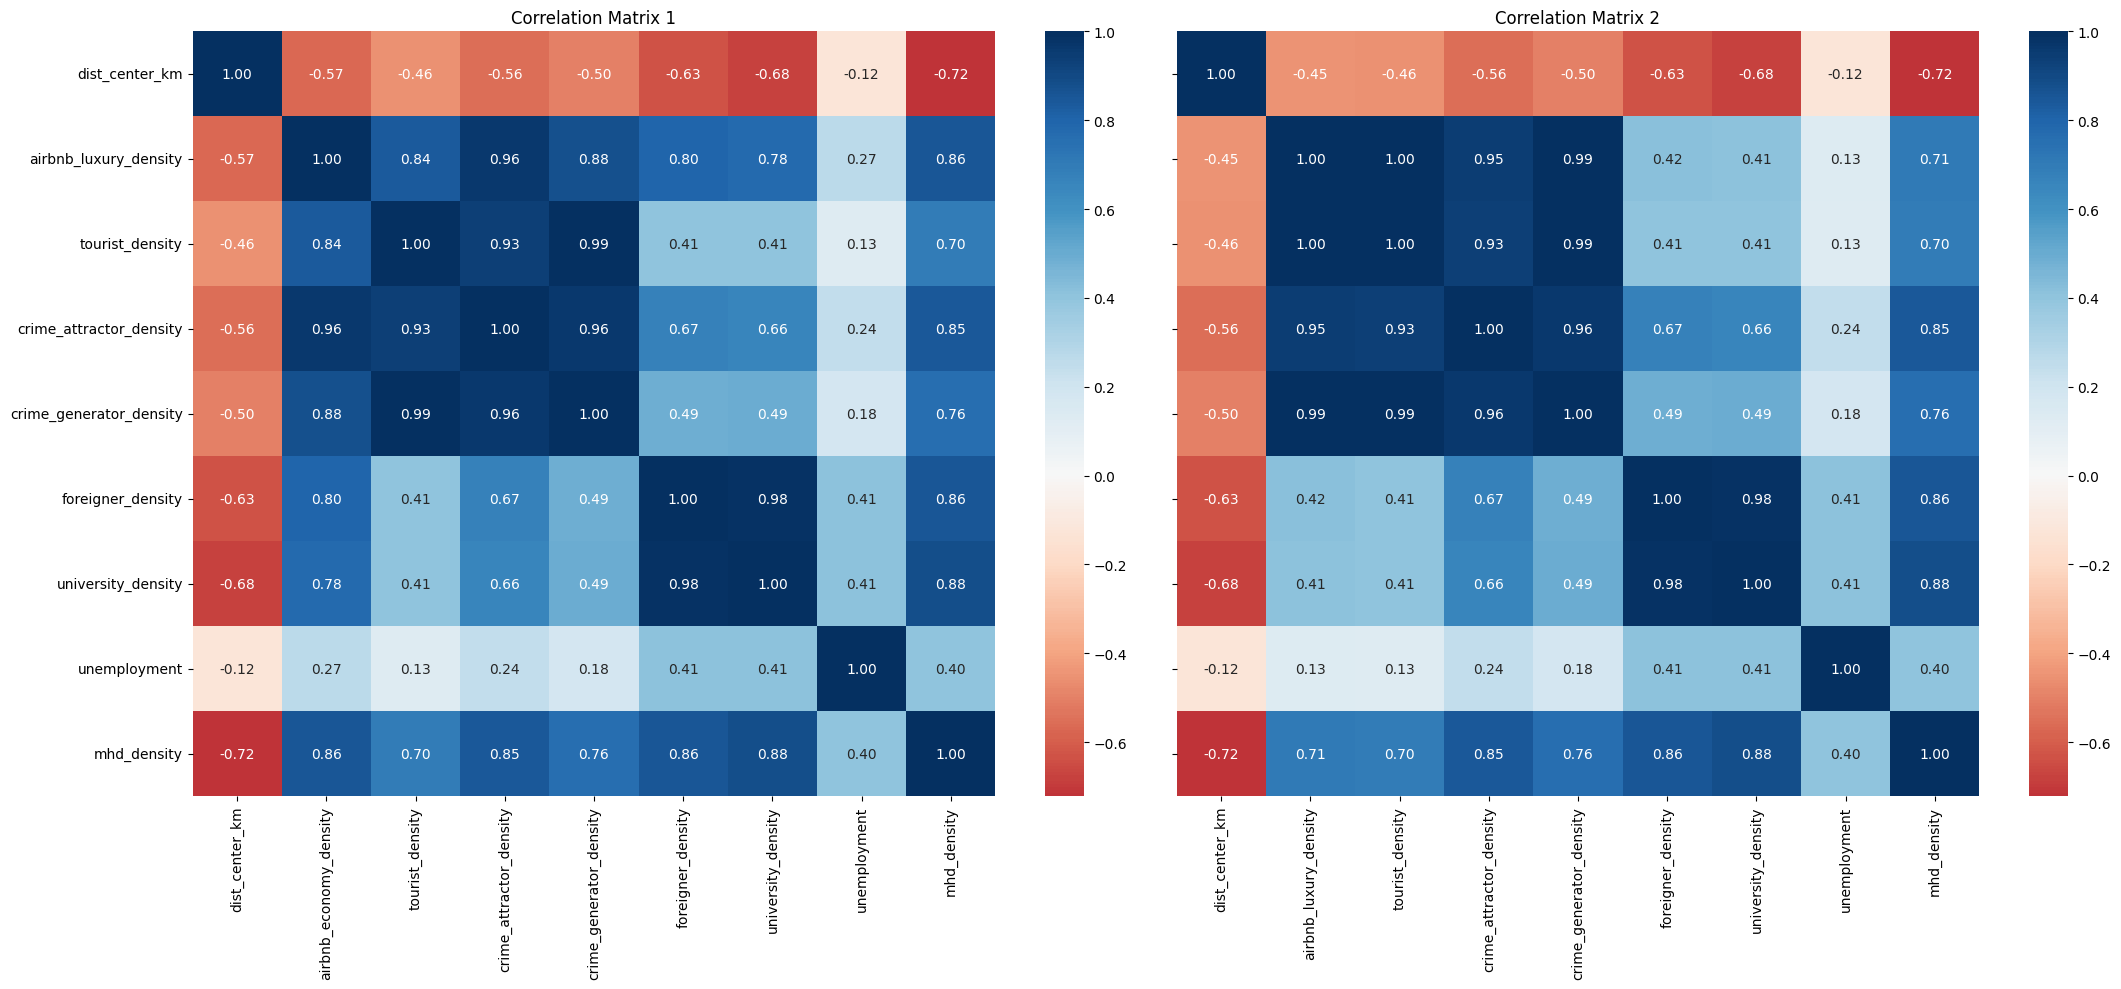

In [475]:
corr_mtx_double(corr_matrix_economy, corr_matrix_luxury)

For a value n of the correlation matrix:
- 0.1 ≤ n < 0.3 → weak positive correlation
- 0.3 ≤ n < 0.5 → moderate positive correlation
- n ≥ 0.5 → strong positive correlation
- –0.3 < n ≤ –0.1 → weak negative correlation
- –0.5 < n ≤ –0.3 → moderate negative correlation
- n ≤ –0.5 → strong negative correlation

Except the variable 'unemployment', which correlates weakly with every other variable, the rest shows strong positive or negative correlation.
Thus, feature selection is critical. There are no significant differences between the matrices of the economy and luxury airbnb.

#### VIF Factor

In [476]:
vif_data_economy = vif_calcul(X, features_economy)
vif_data_luxury = vif_calcul(X, features_luxury)

In [477]:
print("\nEconomy Airbnb VIFs:\n")
print(vif_data_economy.sort_values(by="VIF", ascending=False))

print("\nLuxury Airbnb VIFs:\n")
print(vif_data_luxury.sort_values(by="VIF", ascending=False))


Economy Airbnb VIFs:

                   feature         VIF
4  crime_generator_density  188.644095
3  crime_attractor_density  140.622726
2          tourist_density   99.630622
6       university_density   70.028099
1   airbnb_economy_density   59.235352
5        foreigner_density   58.635890
9                intercept   37.063196
8              mhd_density   23.769432
0           dist_center_km    2.602584
7             unemployment    1.546695

Luxury Airbnb VIFs:

                   feature         VIF
1    airbnb_luxury_density  478.681136
4  crime_generator_density  222.327753
2          tourist_density  173.664330
3  crime_attractor_density  126.288007
6       university_density  110.465339
5        foreigner_density   61.551100
9                intercept   37.503200
8              mhd_density   25.296873
0           dist_center_km    2.609005
7             unemployment    1.679400


For a VIF value n:
- ≈ 1 → no multicollinearity
- 1 – 2 → very low
- 2 – 5 → moderate (still acceptable)
- 5 – 10 → high (needs examination)
- \> 10 → severe

The VIF analysis indicates that unemployment, consistent with the correlation matrix results, dist_center_km, and crime_generator_density have acceptable multicollinearity levels, however, according to the correlation matrix they are already in the grey zone. The remaining variables exhibit high VIF values, suggesting problematic multicollinearity. Therefore, feature selection is employed in the next step to address this issue.

### Removing multicollinearity

##### Stepwise Dropping Features

In [478]:
_features_economy = features_economy.copy()
_features_luxury = features_luxury.copy()

final_features_economy, final_vif_table_economy = stepwise_feature_selection(X, _features_economy)
print("\nFinal VIF Table:\n", final_vif_table_economy)
print()

final_features_luxury, final_vif_table_luxury = stepwise_feature_selection(X, _features_luxury)
print("\nFinal VIF Table:\n", final_vif_table_luxury)

Dropping crime_generator_density with VIF 188.64
Dropping crime_attractor_density with VIF 85.82
Dropping university_density with VIF 61.83
Dropping foreigner_density with VIF 27.32
Dropping mhd_density with VIF 6.66

Final VIF Table:
                   feature       VIF
1  airbnb_economy_density  4.245560
2         tourist_density  3.443399
0          dist_center_km  1.482178
3            unemployment  1.118987

Dropping airbnb_luxury_density with VIF 478.68
Dropping crime_generator_density with VIF 181.22
Dropping university_density with VIF 60.28
Dropping crime_attractor_density with VIF 42.26
Dropping mhd_density with VIF 10.84

Final VIF Table:
              feature       VIF
2  foreigner_density  2.108204
0     dist_center_km  1.889001
1    tourist_density  1.303599
3       unemployment  1.250715


##### Ridge Regression

- Predictors are measured in different units and scales

- Ridge and Lasso apply a penalty based on coefficient magnitude

- Without standardization, variables with large numeric scales are penalized more heavily, regardless of their true importance

- Standardization ensures that the regularization penalty is applied equally across predictors, making coefficient shrinkage comparable and meaningful

In [479]:
X_scaled_econ, y_econ = scale_data(X, features_economy)
X_scaled_lux, y_lux = scale_data(X, features_luxury)

In [480]:
ridge_regression(X_scaled_econ, y_econ, features_economy)
print()
ridge_regression(X_scaled_lux, y_lux, features_luxury)

Best Alpha for Ridge: 1e-06
Ridge Coefficients:
 crime_generator_density    1.646826
mhd_density                1.615875
foreigner_density          1.477863
unemployment              -0.127603
tourist_density           -0.130050
dist_center_km            -0.239510
airbnb_economy_density    -0.289264
university_density        -1.026437
crime_attractor_density   -2.130199
dtype: float64

Best Alpha for Ridge: 0.01
Ridge Coefficients:
 mhd_density                1.696603
crime_generator_density    1.620963
foreigner_density          1.361593
airbnb_luxury_density      0.050211
unemployment              -0.121202
tourist_density           -0.176634
dist_center_km            -0.248973
university_density        -1.045473
crime_attractor_density   -2.372372
dtype: float64


The Ridge results indicate that structural urban factors like MHD (transit) density, foreigner density, and proximity to the center are the primary drivers of crime in Prague, regardless of the rental type. In both models, high transit accessibility emerged as the strongest predictor, suggesting that crime is most concentrated around major transportation hubs. Interestingly, the model chose a high penalty (Alpha 10.0), which stabilized the coefficients and successfully mitigated the extreme multicollinearity that previously skewed your results.

The most critical finding lies in the divergence between the two segments: Luxury Airbnbs show a positive association with crime density (+0.055), while Economy Airbnbs show a slight negative association (-0.036). This suggests that luxury rentals are more closely tied to high-crime areas or are better proxies for the specific urban environments where crime occurs. Because these coefficients are relatively small compared to transit density, running a Lasso regression is the logical next step to see if the Luxury Airbnb effect is mathematically robust enough to be kept in the model or if it will be zeroed out as noise.

##### Lasso Regression

In [481]:
lasso_regression(X_scaled_econ, y_econ, features_economy)
print()
lasso_regression(X_scaled_lux, y_lux, features_luxury)

Best Alpha for Lasso: 0.0012021319474553966
Lasso Coefficients:
 mhd_density                1.556682
crime_generator_density    1.326616
foreigner_density          1.260337
tourist_density            0.000000
unemployment              -0.113861
dist_center_km            -0.245982
airbnb_economy_density    -0.338079
university_density        -0.816004
crime_attractor_density   -1.845016
dtype: float64



/home/teruna/Documents/cvut_fel/engineer/san/_semestral_work/SAN/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1682: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
/home/teruna/Documents/cvut_fel/engineer/san/_semestral_work/SAN/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1682: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(


Best Alpha for Lasso: 0.0012890066837878582
Lasso Coefficients:
 mhd_density                1.662321
crime_generator_density    1.333671
foreigner_density          1.172796
tourist_density            0.000000
airbnb_luxury_density      0.000000
unemployment              -0.108746
dist_center_km            -0.253611
university_density        -0.879745
crime_attractor_density   -2.171901
dtype: float64


The Lasso results provide the ultimate "feature selection" by mathematically zeroing out the variables that do not contribute unique explanatory power. In both models, MHD density and foreigner density remain the most dominant predictors, with transit accessibility seeing its influence nearly double compared to the Ridge model. Notably, Lasso has completely eliminated university density and tourist_density in the economy model (setting them to 0.000), effectively deciding that these variables were redundant "noise" once transit and foreigner populations were accounted for.

The comparison between rental segments is now even sharper: Luxury Airbnbs survived the "zeroing" process with a positive coefficient of approximately 0.10, confirming that luxury rentals have a robust, non-zero association with higher crime density. Conversely, Economy Airbnbs retained a small negative coefficient (-0.04), suggesting they play a much smaller and fundamentally different role in the urban landscape. Essentially, the Lasso model suggests that while general tourism might be redundant, the specific presence of luxury short-term rentals provides a unique signal for crime density that other variables cannot capture.

No significant difference between economy and luxury airbnb density in the areas was proven.

## Dimensionality Reduction and Clustering

Since the estimated coefficients and overall model behavior of the economy and luxury specifications are largely analogous, principal component analysis is conducted exclusively for the economy model.

PC1 explains 69.19% of the variance.
PC2 explains 15.33% of the variance.
PC3 explains 9.34% of the variance.


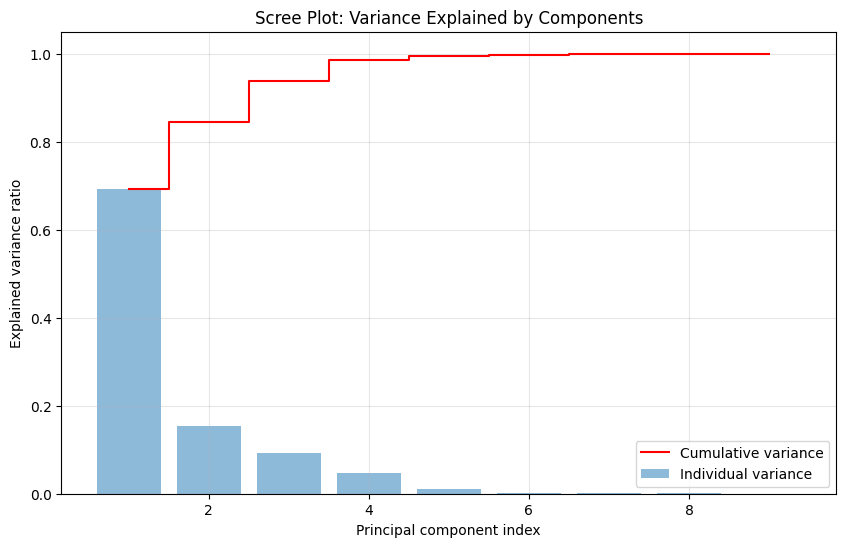

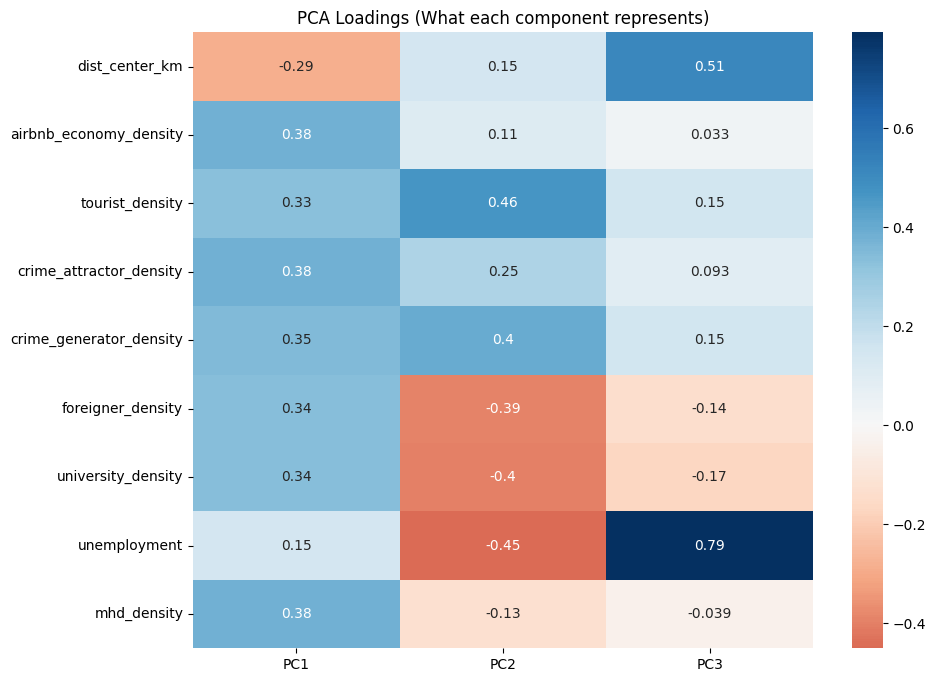

In [482]:
from sklearn.decomposition import PCA

pca = PCA()
pca_features = pca.fit_transform(X_scaled_econ)

scree_plot(pca)
pca_loadings(pca, features_economy)

# 6. Add the Top Components back to your DataFrame for the GLM
# Usually, PC1 and PC2 are enough
X['urban_intensity_pc11'] = pca_features[:, 0]
X['social_structure_pc2'] = pca_features[:, 1]

print(f"PC1 explains {pca.explained_variance_ratio_[0]:.2%} of the variance.")
print(f"PC2 explains {pca.explained_variance_ratio_[1]:.2%} of the variance.")
print(f"PC3 explains {pca.explained_variance_ratio_[2]:.2%} of the variance.")

PC1 explains 67.01% of the variance.
PC2 explains 18.21% of the variance.
PC3 explains 9.48% of the variance.


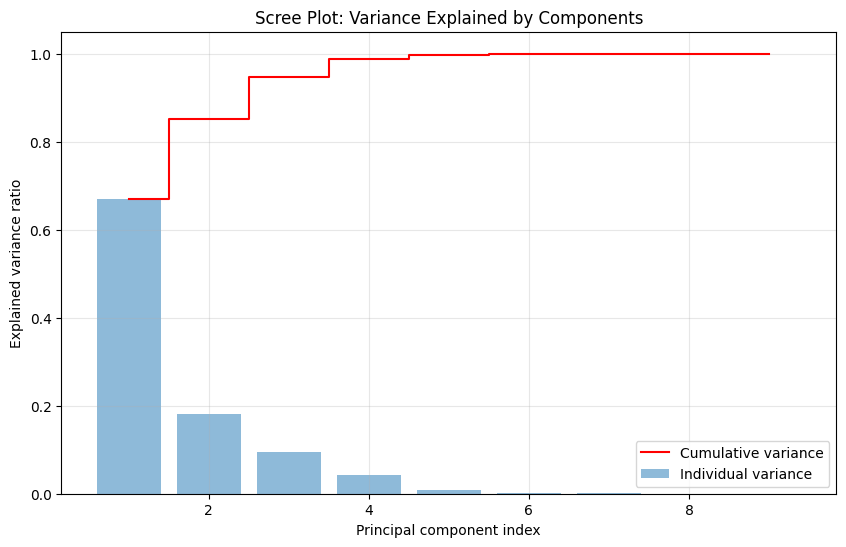

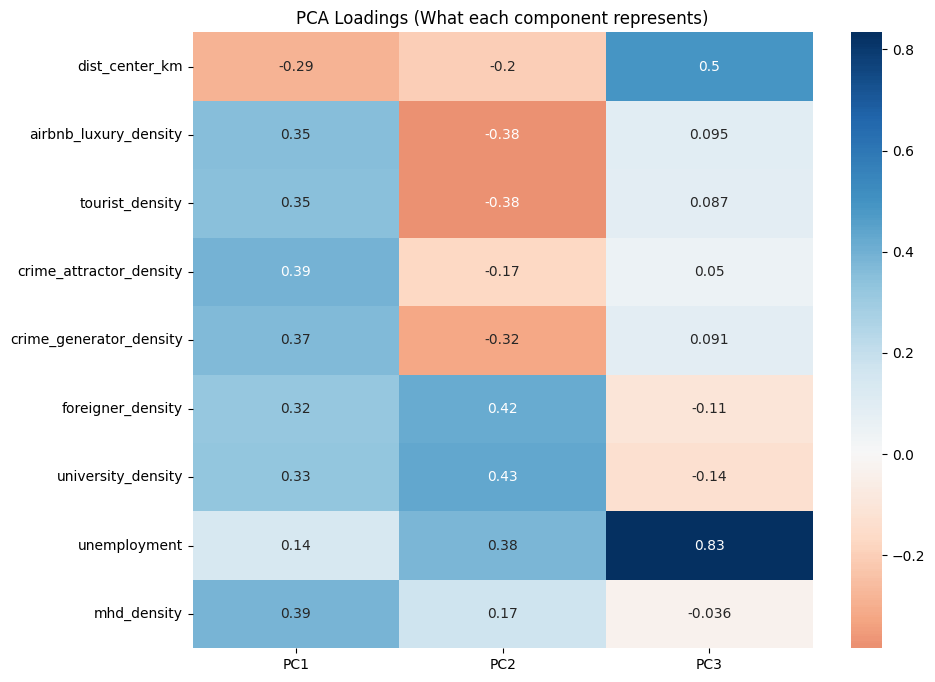

In [483]:
pca = PCA()
pca_features = pca.fit_transform(X_scaled_lux)

scree_plot(pca)
pca_loadings(pca, features_luxury)

# 6. Add the Top Components back to your DataFrame for the GLM
# Usually, PC1 and PC2 are enough
X['urban_intensity_pc11'] = pca_features[:, 0]
X['social_structure_pc2'] = pca_features[:, 1]

print(f"PC1 explains {pca.explained_variance_ratio_[0]:.2%} of the variance.")
print(f"PC2 explains {pca.explained_variance_ratio_[1]:.2%} of the variance.")
print(f"PC3 explains {pca.explained_variance_ratio_[2]:.2%} of the variance.")

The economy and luxury models differ mostly in the second principal component PC2, where each relationship is reversed - where was weak positive score in the economy model, is weak negative score in the second model. 

This might suggest, that the crime slightly increases with density of economy airbnbs and decreases with more expensive ones.

# Influence Of Airbnbs On Particular Crime Type

#### Simple OLS Models

We compute with general airbnb_density, where we do not distinguish between economy and luxury as far as no big differences between them was proven.

In [484]:
lm_burglary = smf.ols('crime_Burglary_density ~ dist_center_km + airbnb_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=df).fit()

lm_disorder = smf.ols('crime_Disorder_density ~ dist_center_km + airbnb_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=df).fit()

lm_theft = smf.ols('crime_Theft_density ~ dist_center_km + airbnb_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=df).fit()

lm_violent = smf.ols('crime_Violent_density ~ dist_center_km + airbnb_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=df).fit()

lm_other = smf.ols('crime_Other_density ~ dist_center_km + airbnb_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=df).fit()

## Outliers

#### Analysing Outliers

In [485]:
# outliers detection using Cook's distance
outliers_burglary, cooks_d_burglary = detect_outliers(lm_burglary)
print(f"Outliers of burglary model: {outliers_burglary}")

outliers_disorder, cooks_d_disorder = detect_outliers(lm_disorder)
print(f"Outliers of disorder model: {outliers_disorder}")

outliers_theft, cooks_d_theft = detect_outliers(lm_theft)
print(f"Outliers of theft model: {outliers_theft}")

outliers_violent, cooks_d_violent = detect_outliers(lm_violent)
print(f"Outliers of violent model: {outliers_violent}")

outliers_other, cooks_d_other = detect_outliers(lm_other)
print(f"Outliers of other model: {outliers_other}")

Outliers of burglary model: [ 0  1  8 11 15 16 19 46]
Outliers of disorder model: [ 0  8  9 15 19 46]
Outliers of theft model: [ 0  1  2  8 11 15 18 19 46 56]
Outliers of violent model: [ 0  1  8 11 15 18 19 46]
Outliers of other model: [ 0  2  8 11 15 19 21 41 46]


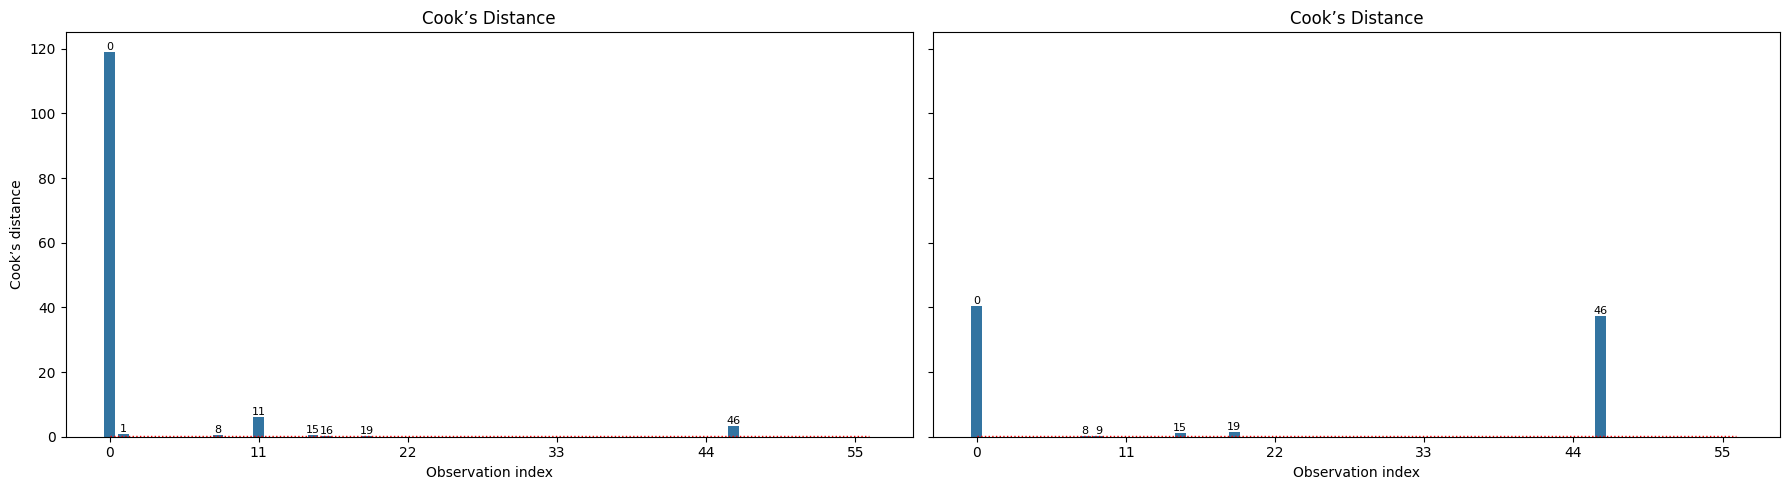

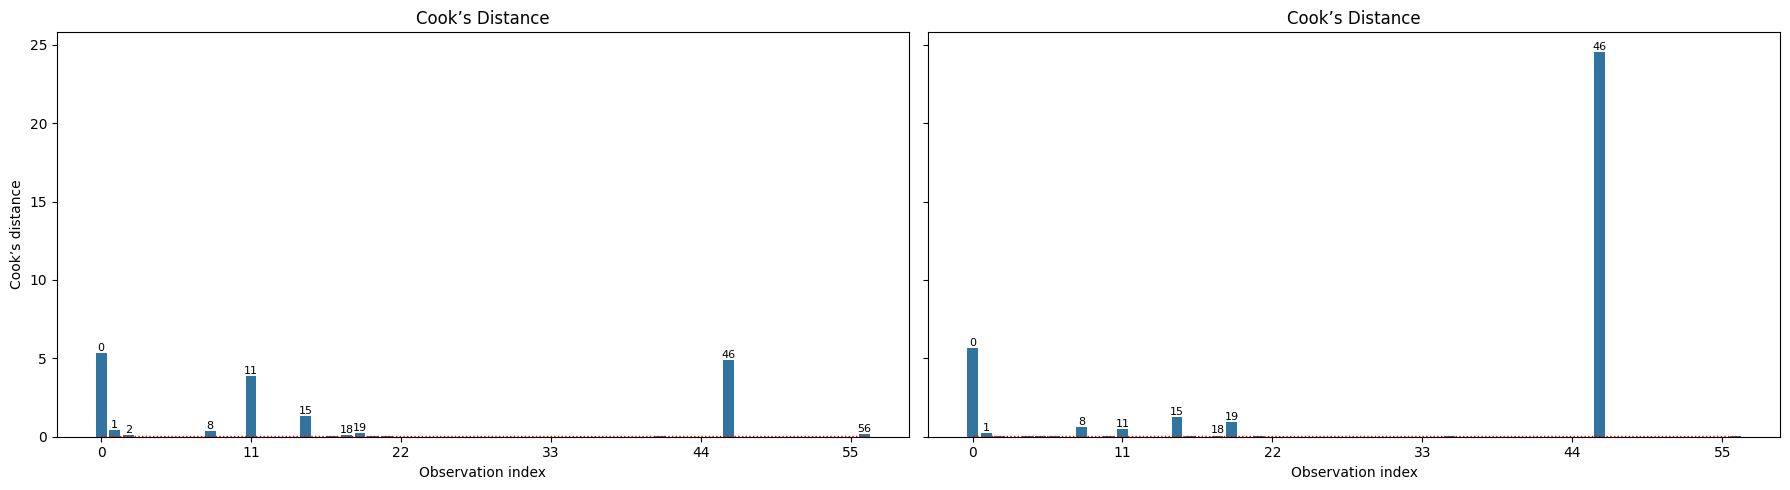

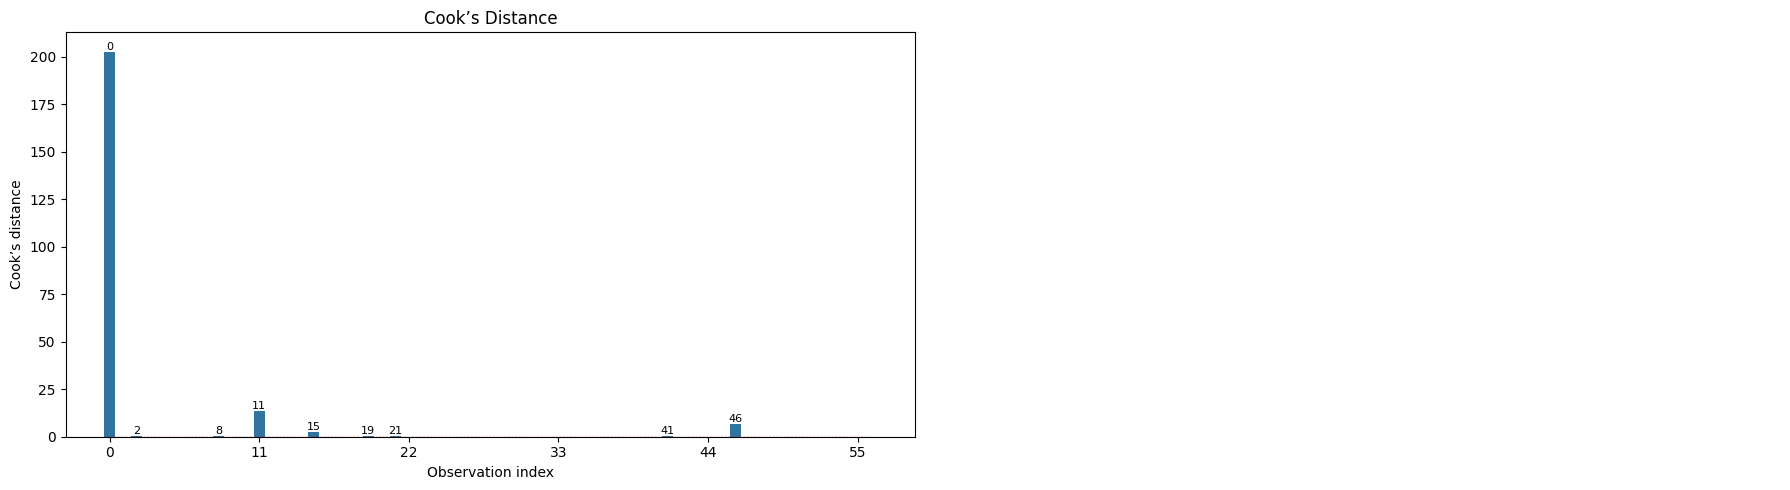

In [486]:
outliers_double_plot(cooks_d_burglary, cooks_d_disorder, outliers_burglary, outliers_disorder)
outliers_double_plot(cooks_d_theft, cooks_d_violent, outliers_theft, outliers_violent)
outlier_single_plot(cooks_d_other, outliers_other)

Similarly to the previous analysis, also here are districts with the highest airbnb density marked as outliers, so we remove only those less important for our study.

#### Remove outliers

In [487]:
X_bulglary = df.drop([1, 8, 16, 46])
X_disorder = df.drop([8, 9, 46])
X_theft = df.drop([1, 8, 18, 46, 56])
X_violent = df.drop([1, 8, 18, 46])
X_other = df.drop([8, 21, 41, 46])

## Linearity and Homoscedasticity

#### Create simple OLS models without outliers

In [488]:
lm_burglary = smf.ols('crime_Burglary_density ~ dist_center_km + airbnb_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=X_bulglary).fit()

lm_disorder = smf.ols('crime_Disorder_density ~ dist_center_km + airbnb_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=X_disorder).fit()

lm_theft = smf.ols('crime_Theft_density ~ dist_center_km + airbnb_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=X_theft).fit()

lm_violent = smf.ols('crime_Violent_density ~ dist_center_km + airbnb_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=X_violent).fit()

lm_other = smf.ols('crime_Other_density ~ dist_center_km + airbnb_density + ' \
    'crime_attractor_density + crime_generator_density + tourist_density + ' \
    'foreigner_density + university_density + unemployment + mhd_density', data=X_other).fit()

#### Analysis of linearity and homoscedasticity quality

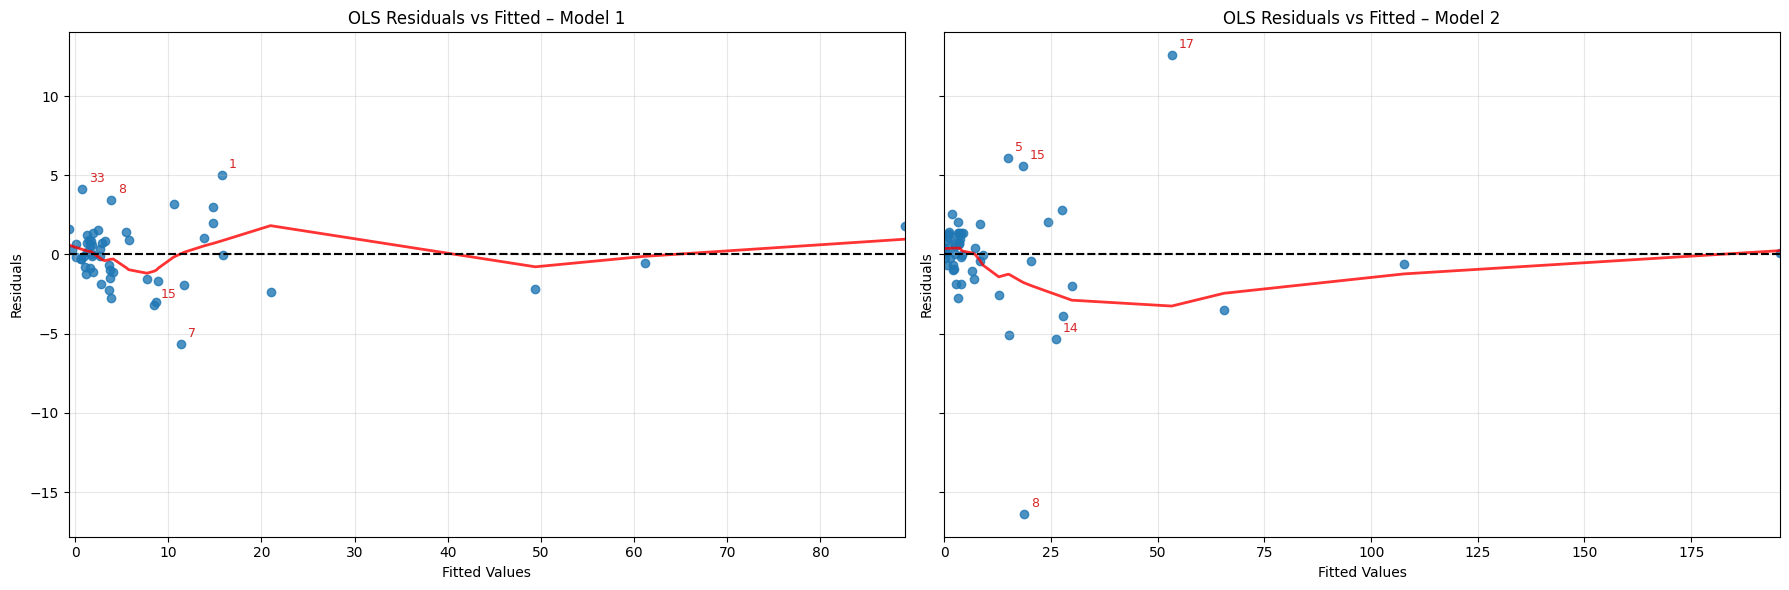

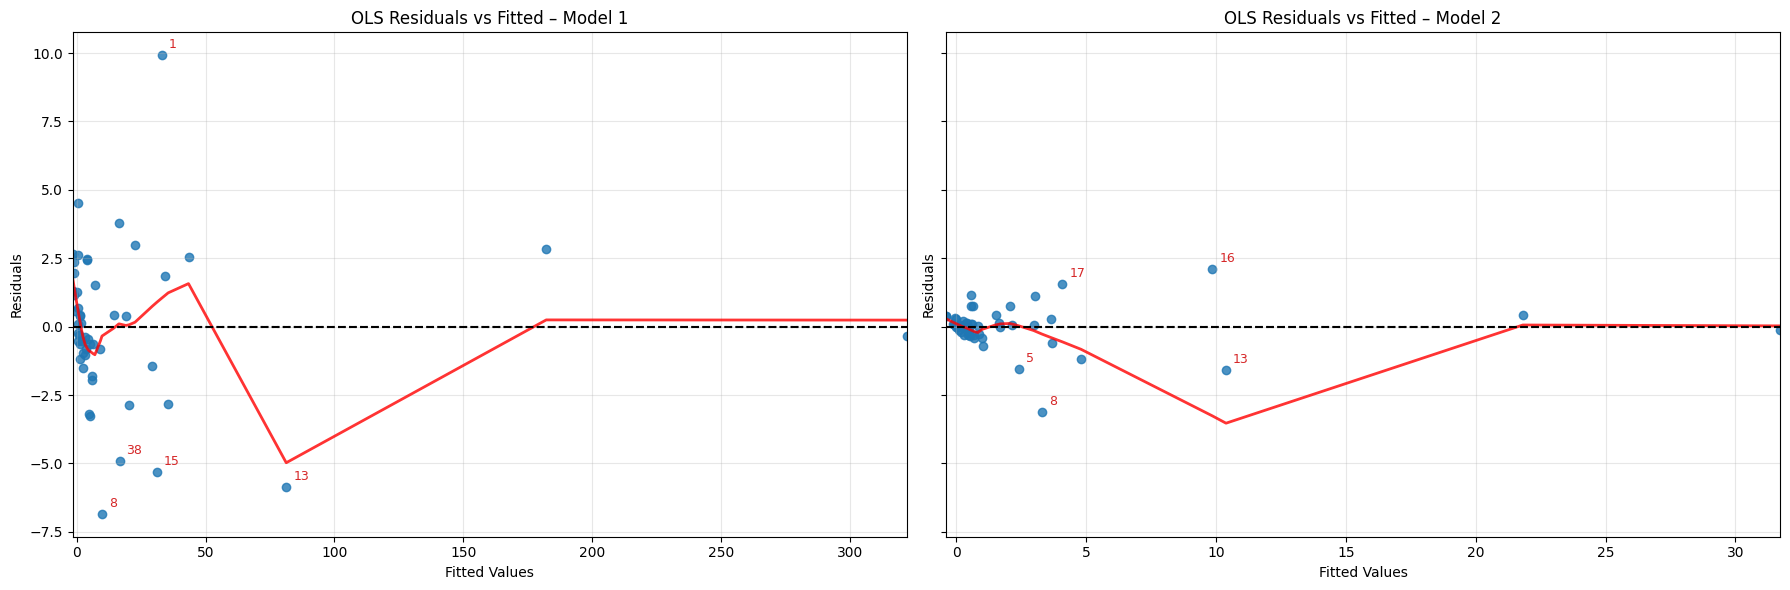

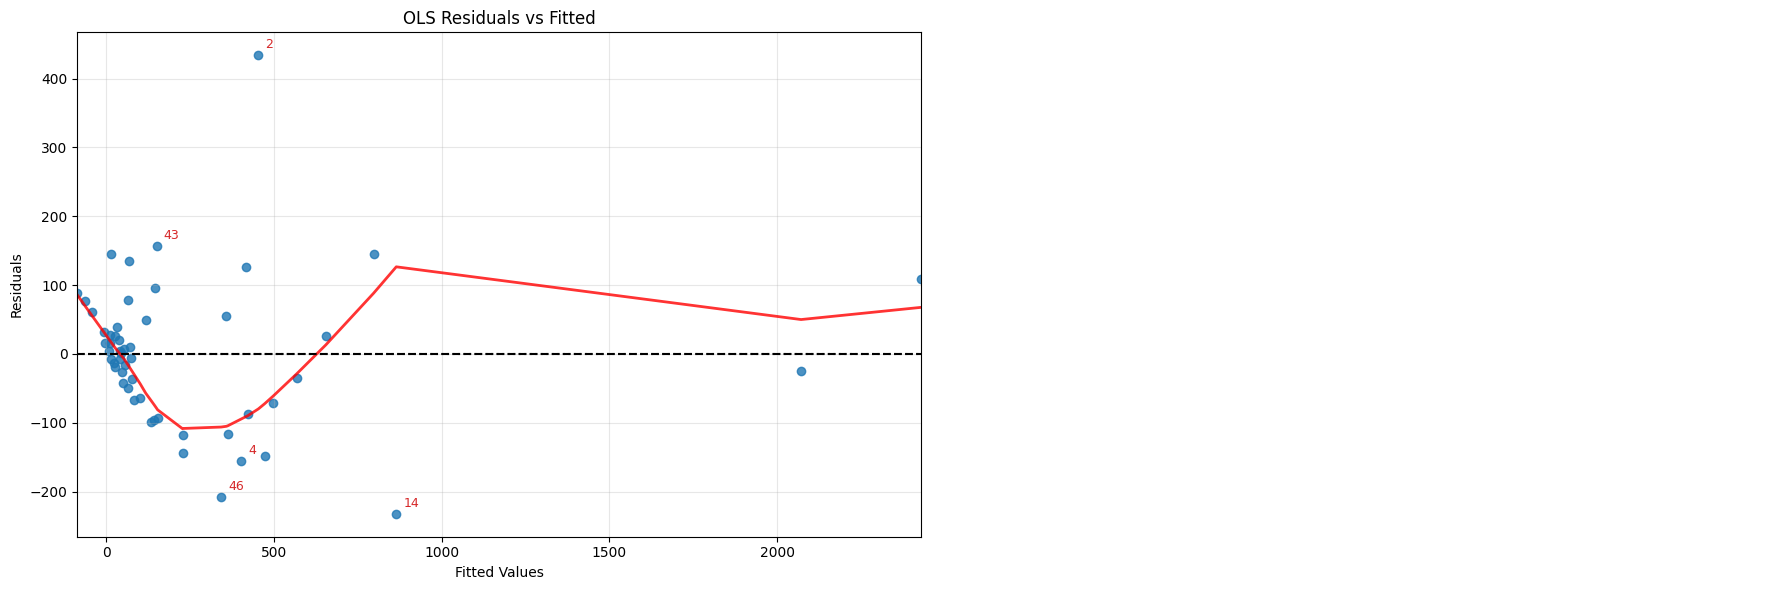

In [489]:
res_vs_fitted_ols_double(lm_burglary, lm_disorder)
res_vs_fitted_ols_double(lm_theft, lm_violent)
res_vs_fitted_ols_single(lm_other)

According to the residuals vs fitted plot the data are skewed and we might need to switch to GLM models and do feature transformation.

#### More Features Diagnostics

For better understanding of the features in the models we use Component-Component plus Residual (CCPR) Plot, also known as a Partial Residual Plot.

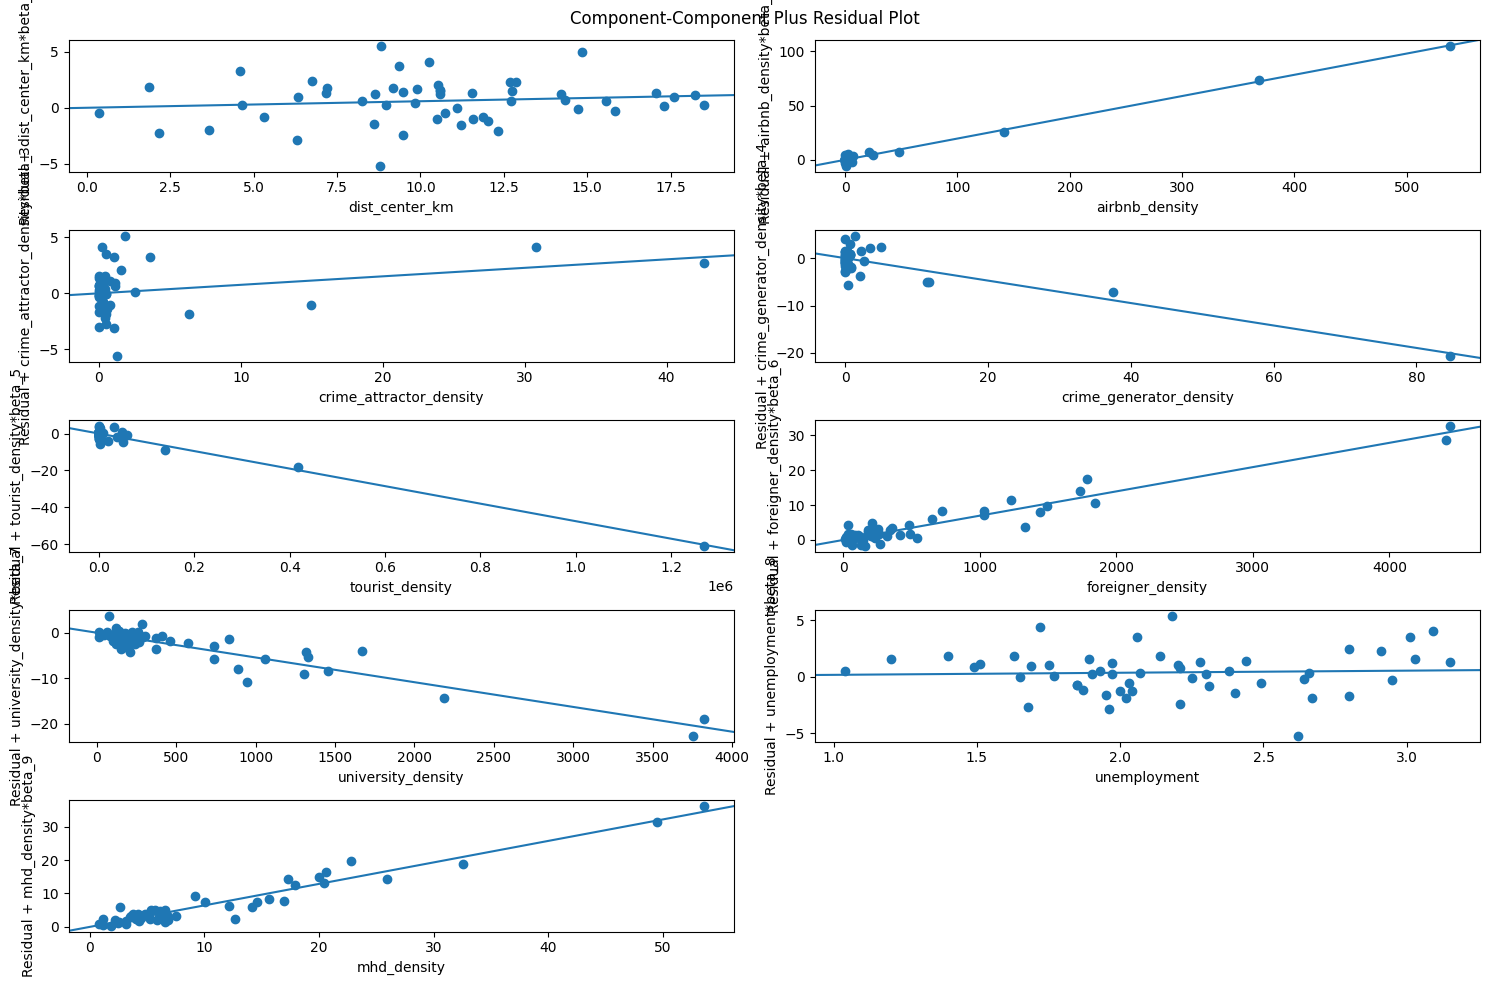

In [490]:
ccpr_plot(lm_burglary)

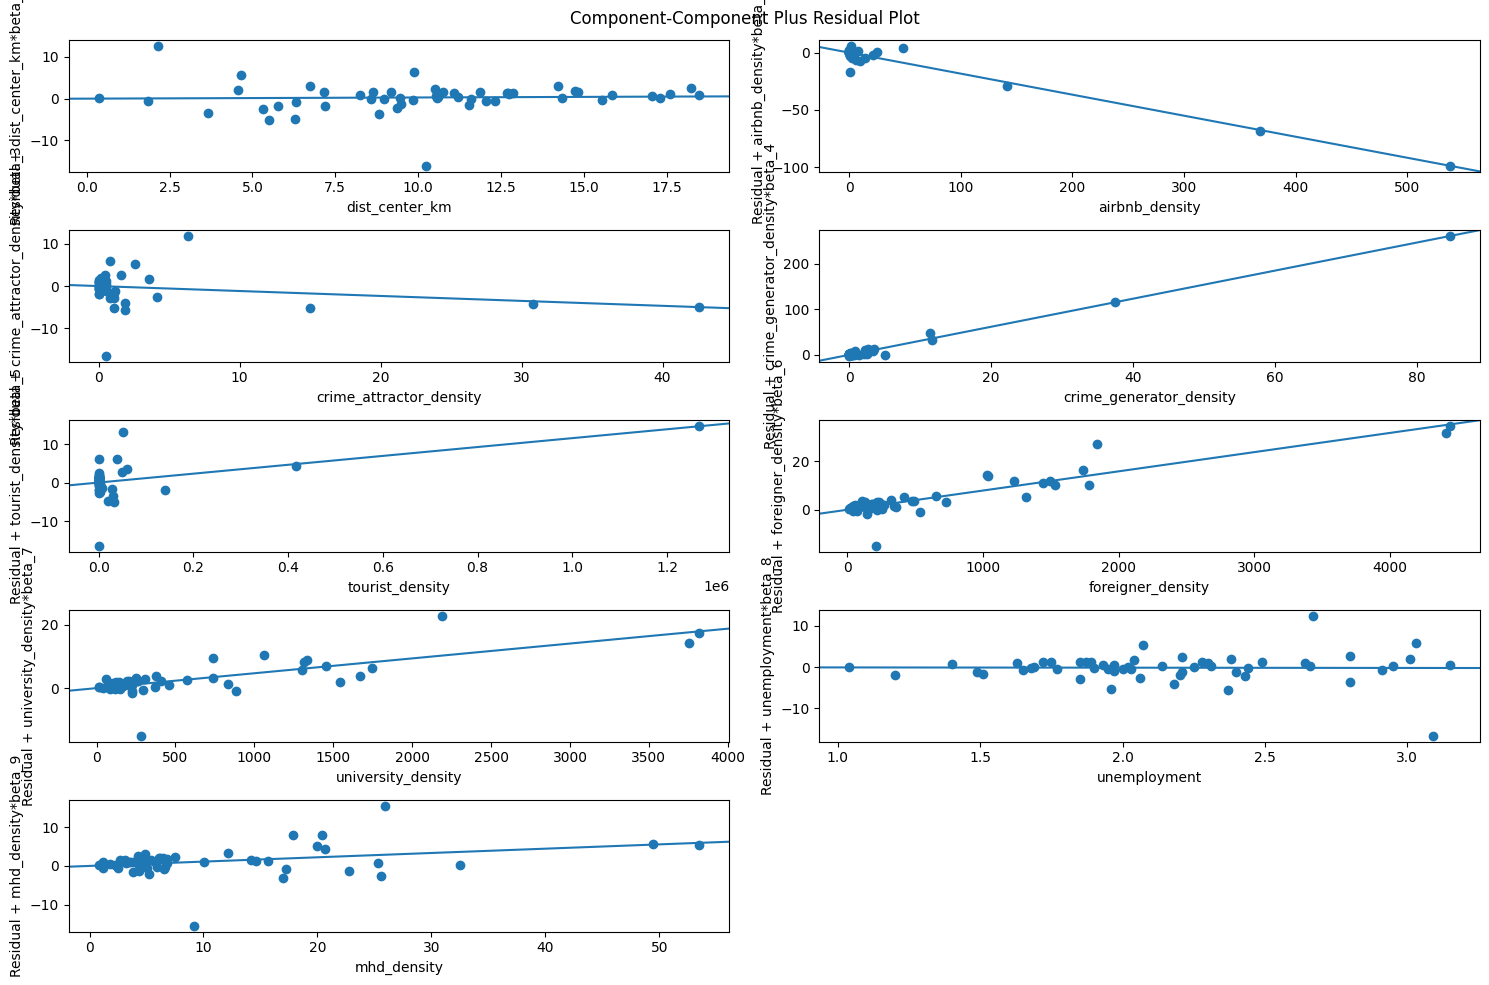

In [491]:
ccpr_plot(lm_disorder)

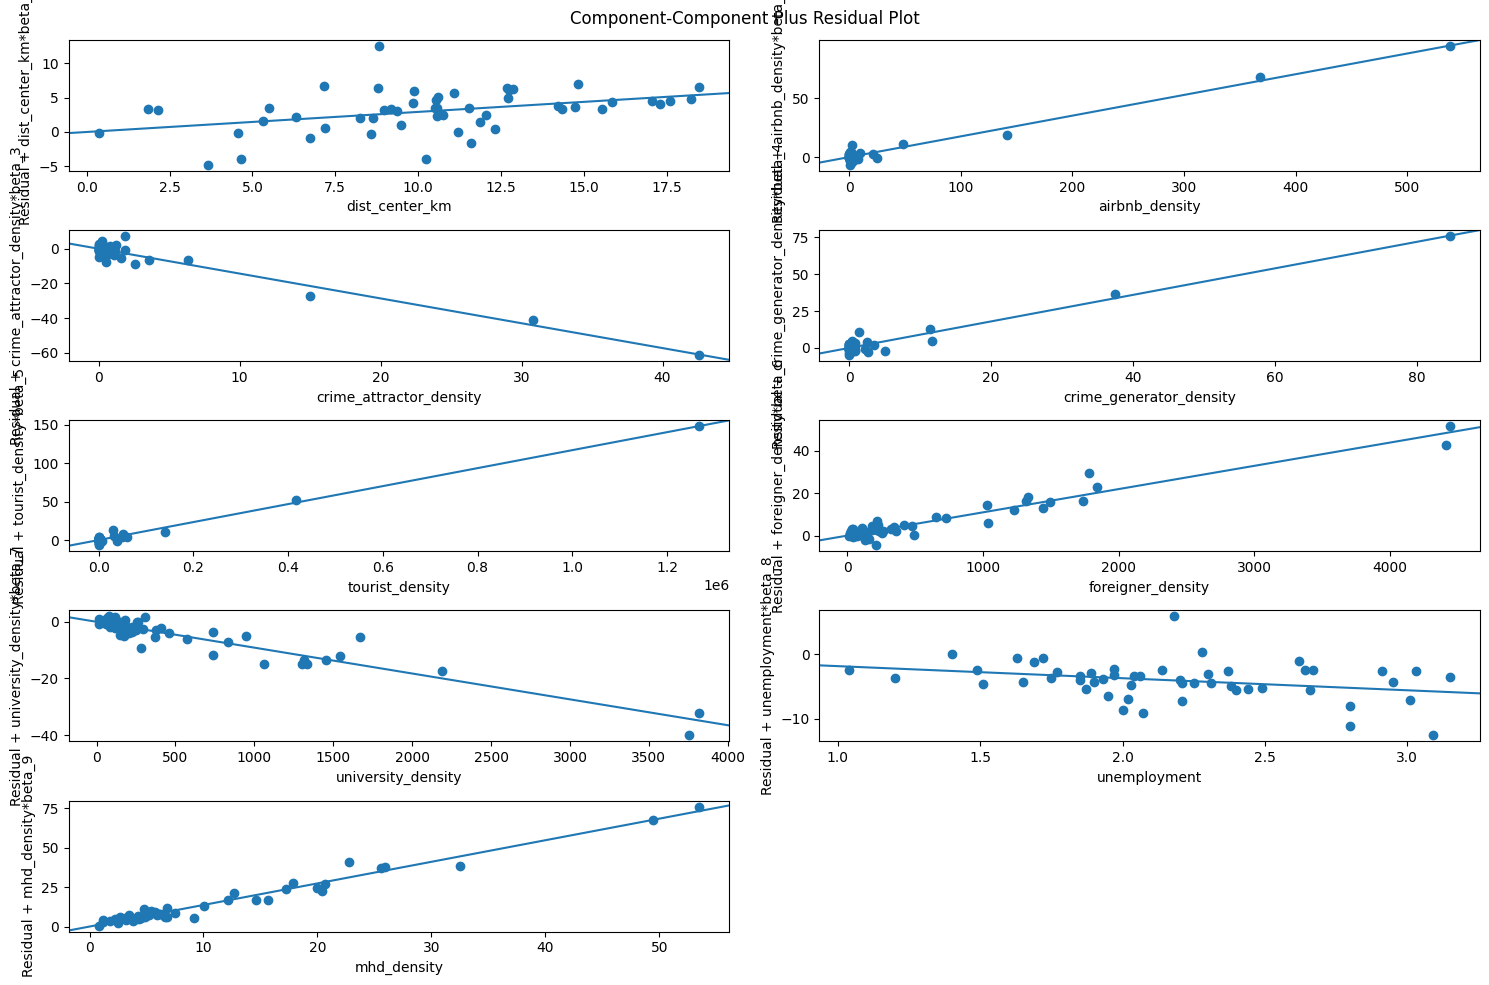

In [492]:
ccpr_plot(lm_theft)

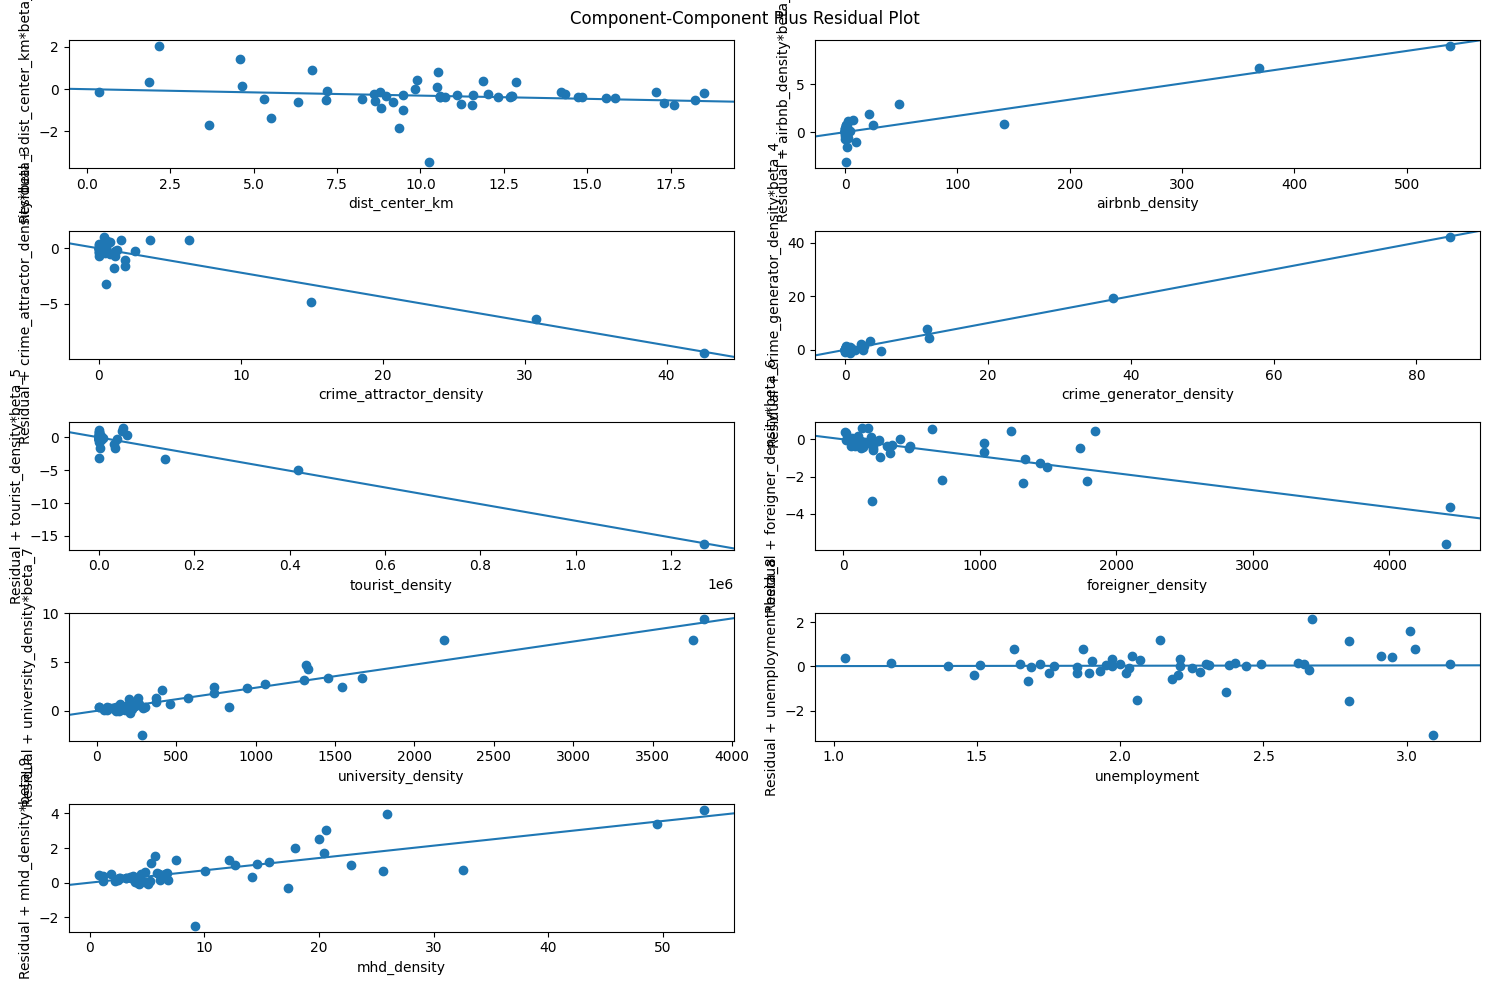

In [493]:
ccpr_plot(lm_violent)

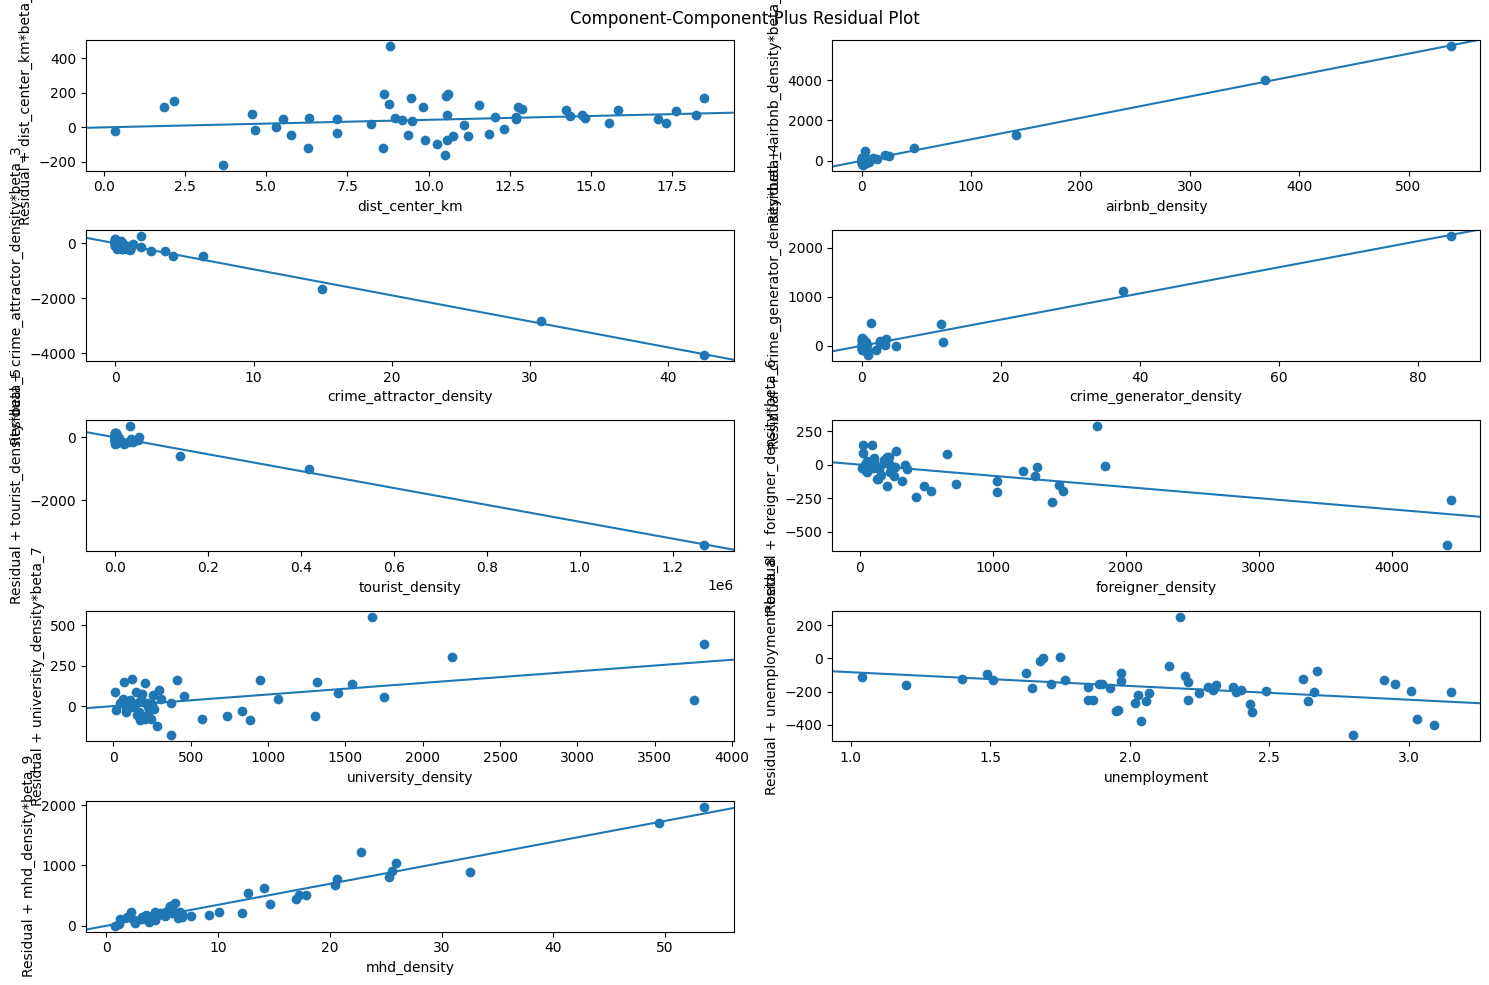

In [494]:
ccpr_plot(lm_other)

In each model the features in the CCPR plot follows the same pattern:
- dist_center_km and unemployment → mostly linear variables, in some plots the values concentrate a little more in the center → so we add parabolic variable _I(var**2)_ in such cases
- the rest of the variables have the points visibly concentrated on the begining, which signals logarithmic development → we transform such variable by logarithm _np.log1p(var)_

In [495]:
formula_burglary = ('np.log1p(crime_Burglary_density) ~ dist_center_km + I(dist_center_km**2) + np.log1p(airbnb_density) + '
    'np.log1p(crime_attractor_density) + np.log1p(crime_generator_density) + '
    'np.log1p(tourist_density) + np.log1p(foreigner_density) + '
    'np.log1p(university_density) + unemployment + np.log1p(mhd_density)'
)

formula_disorder = ('np.log1p(crime_Disorder_density) ~ dist_center_km + I(dist_center_km**2) + np.log1p(airbnb_density) + '
    'np.sqrt(crime_attractor_density) + np.log1p(crime_generator_density) + '
    'np.log1p(tourist_density) + np.log1p(foreigner_density) + '
    'np.log1p(university_density) + unemployment +  I(unemployment**2) + np.log1p(mhd_density)'
)

formula_theft = ('np.log1p(crime_Theft_density) ~ dist_center_km + I(dist_center_km**2) + np.log1p(airbnb_density) + '
    'np.log1p(crime_attractor_density) + np.log1p(crime_generator_density) + '
    'np.log1p(tourist_density) + np.log1p(foreigner_density) + '
    'np.log1p(university_density) + unemployment +  I(unemployment**2) + np.log1p(mhd_density)'
)
 
formula_violent = ('np.log1p(crime_Violent_density) ~ dist_center_km + np.log1p(airbnb_density) + '
    'np.log1p(crime_attractor_density) + np.sqrt(crime_generator_density) + '
    'np.log1p(tourist_density) + np.sqrt(foreigner_density) + '
    'np.log1p(university_density) + unemployment + np.sqrt(mhd_density)'
)

formula_other = ('np.log1p(crime_Other_density) ~ dist_center_km + I(dist_center_km**2) + np.log1p(airbnb_density) + '
    'np.log1p(crime_attractor_density) + np.log1p(crime_generator_density) + '
    'np.log1p(tourist_density) + np.log1p(foreigner_density) + '
    'np.log1p(university_density) + unemployment +  I(unemployment**2) + np.log1p(mhd_density)'
)

In [496]:
glm_burglary = smf.glm(
    formula=formula_burglary, 
    data=X_bulglary, 
    family=sm.families.Gaussian()
).fit()

glm_disorder = smf.glm(
    formula=formula_disorder, 
    data=X_disorder,
    family=sm.families.Gaussian()
).fit()

glm_theft = smf.glm(
    formula=formula_theft, 
    data=X_theft, 
    family=sm.families.Gaussian()
).fit()

glm_violent = smf.glm(
    formula=formula_violent, 
    data=X_violent, 
    family=sm.families.Gaussian()
).fit()

glm_other = smf.glm(
    formula=formula_other, 
    data=X_other,
    family=sm.families.Gaussian()
).fit()

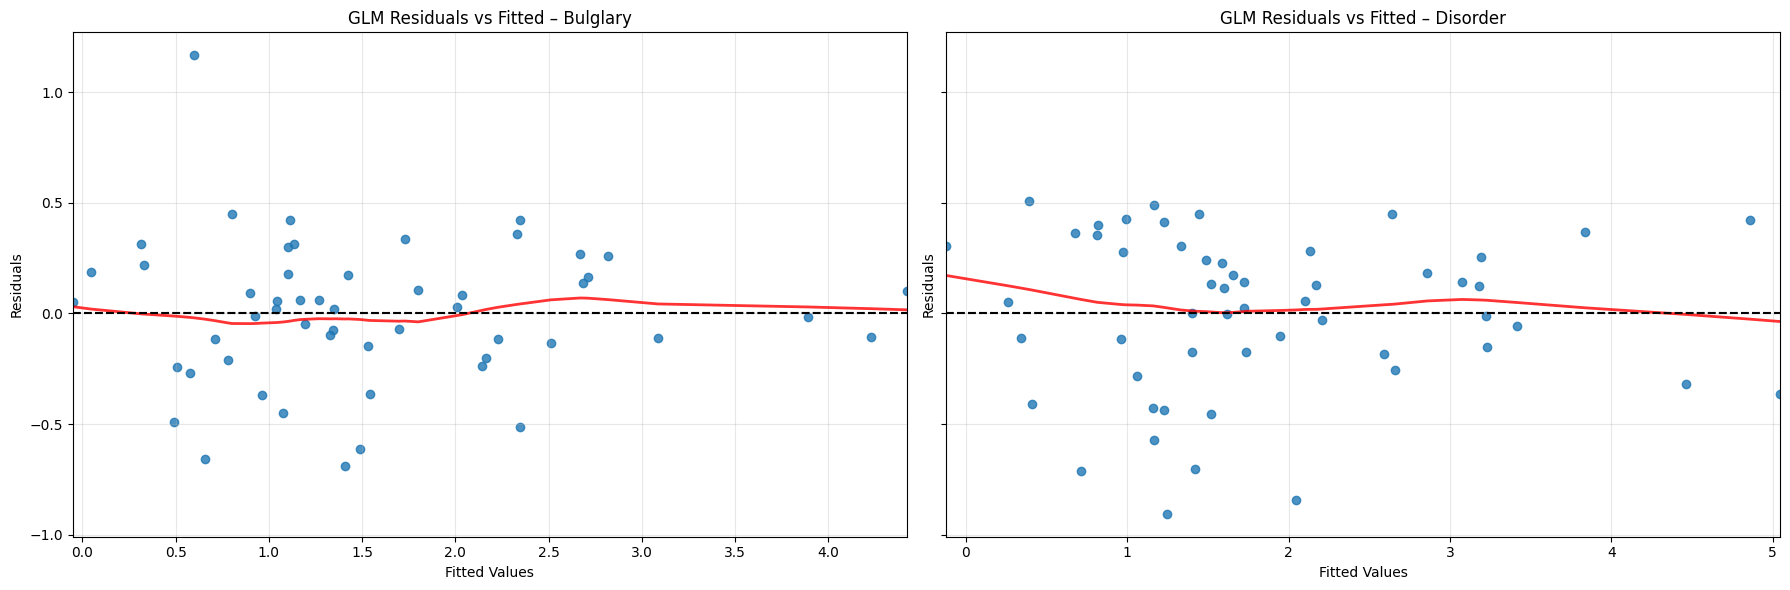

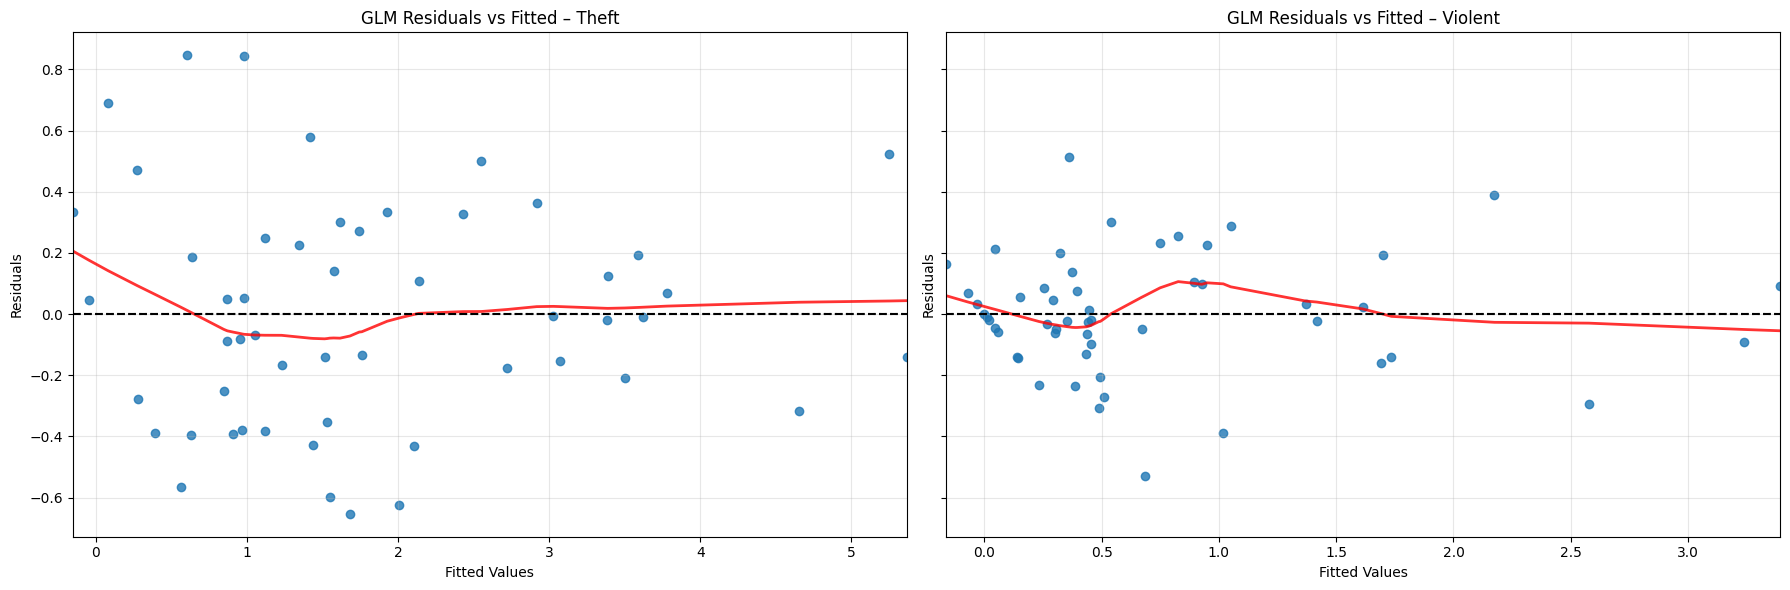

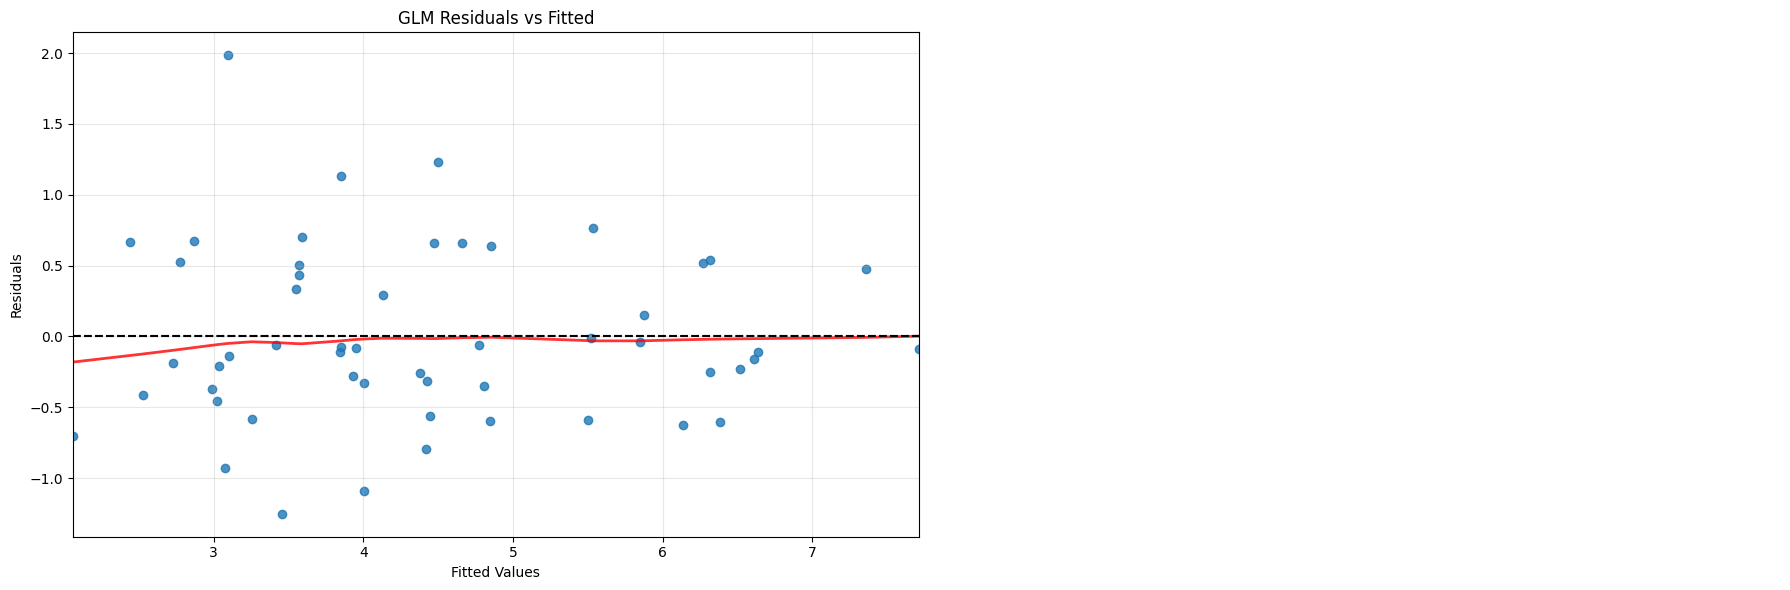

In [497]:
res_vs_fitted_glm_double(glm_burglary, glm_disorder, titles=("Bulglary", "Disorder"))
res_vs_fitted_glm_double(glm_theft, glm_violent, titles=("Theft", "Violent"))
res_vs_fitted_glm_single(glm_other)

In [498]:
_, pval, __, ___ = het_breuschpagan(glm_burglary.resid_deviance, glm_burglary.model.exog)
print(f"Breusch-Pagan p-value - burglary: {pval}")

_, pval, __, ___ = het_breuschpagan(glm_disorder.resid_deviance, glm_disorder.model.exog)
print(f"Breusch-Pagan p-value - disorder: {pval}")

_, pval, __, ___ = het_breuschpagan(glm_theft.resid_deviance, glm_theft.model.exog)
print(f"Breusch-Pagan p-value - theft:    {pval}")

_, pval, __, ___ = het_breuschpagan(glm_violent.resid_deviance, glm_violent.model.exog)
print(f"Breusch-Pagan p-value - violance: {pval}")

_, pval, __, ___ = het_breuschpagan(glm_other.resid_deviance, glm_other.model.exog)
print(f"Breusch-Pagan p-value - other:    {pval}")

Breusch-Pagan p-value - burglary: 0.521029106421511
Breusch-Pagan p-value - disorder: 0.06764044484065826
Breusch-Pagan p-value - theft:    0.39218970913563805
Breusch-Pagan p-value - violance: 0.36037496529029295
Breusch-Pagan p-value - other:    0.44952069397487093


After the necessary feature transformations, the assumptions of the model are sufficiently satisfied. Therefore, there is no need to use a distributional family other than Gaussian, and ordinary least squares (OLS) regression is sufficient.

Some of the Residual vs Fitted plots might not seem flat enough, however, we have to take into account the y-axis scale, which is tiny (between 0.5 - 0.9) and also, Breusch-Pagan p-value proved adequate homoscedasticity to continue in the study.

## Multicollinearity and Feature Selection

#### Correlation Matrix

In [499]:
features = ['dist_center_km', 'airbnb_density', 'tourist_density', 
            'crime_attractor_density', 'crime_generator_density', 
            'foreigner_density', 'university_density', 'unemployment', 'mhd_density']

In [500]:
corr_matrix_bulglary = X_bulglary[features].corr()
corr_matrix_disorder = X_disorder[features].corr()
corr_matrix_theft = X_theft[features].corr()
corr_matrix_violent = X_violent[features].corr()
corr_matrix_other = X_other[features].corr()

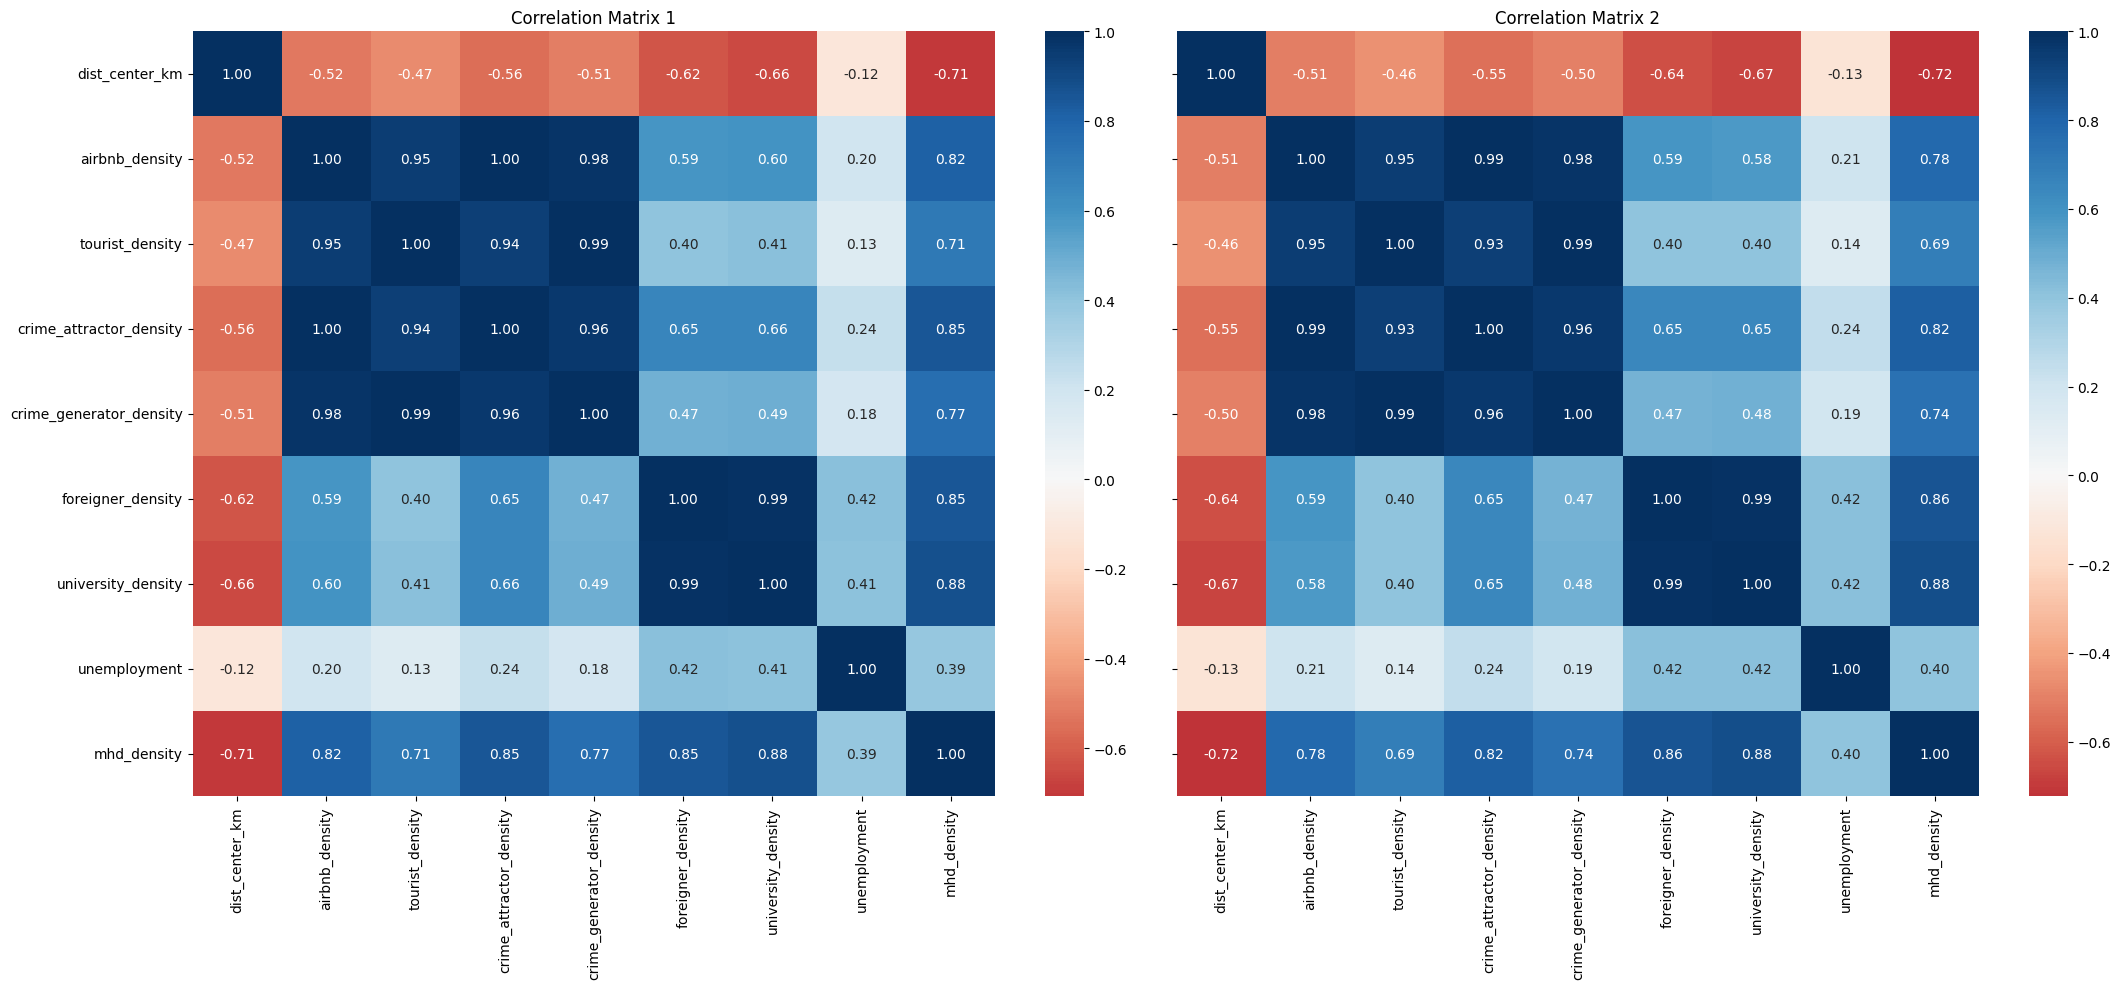

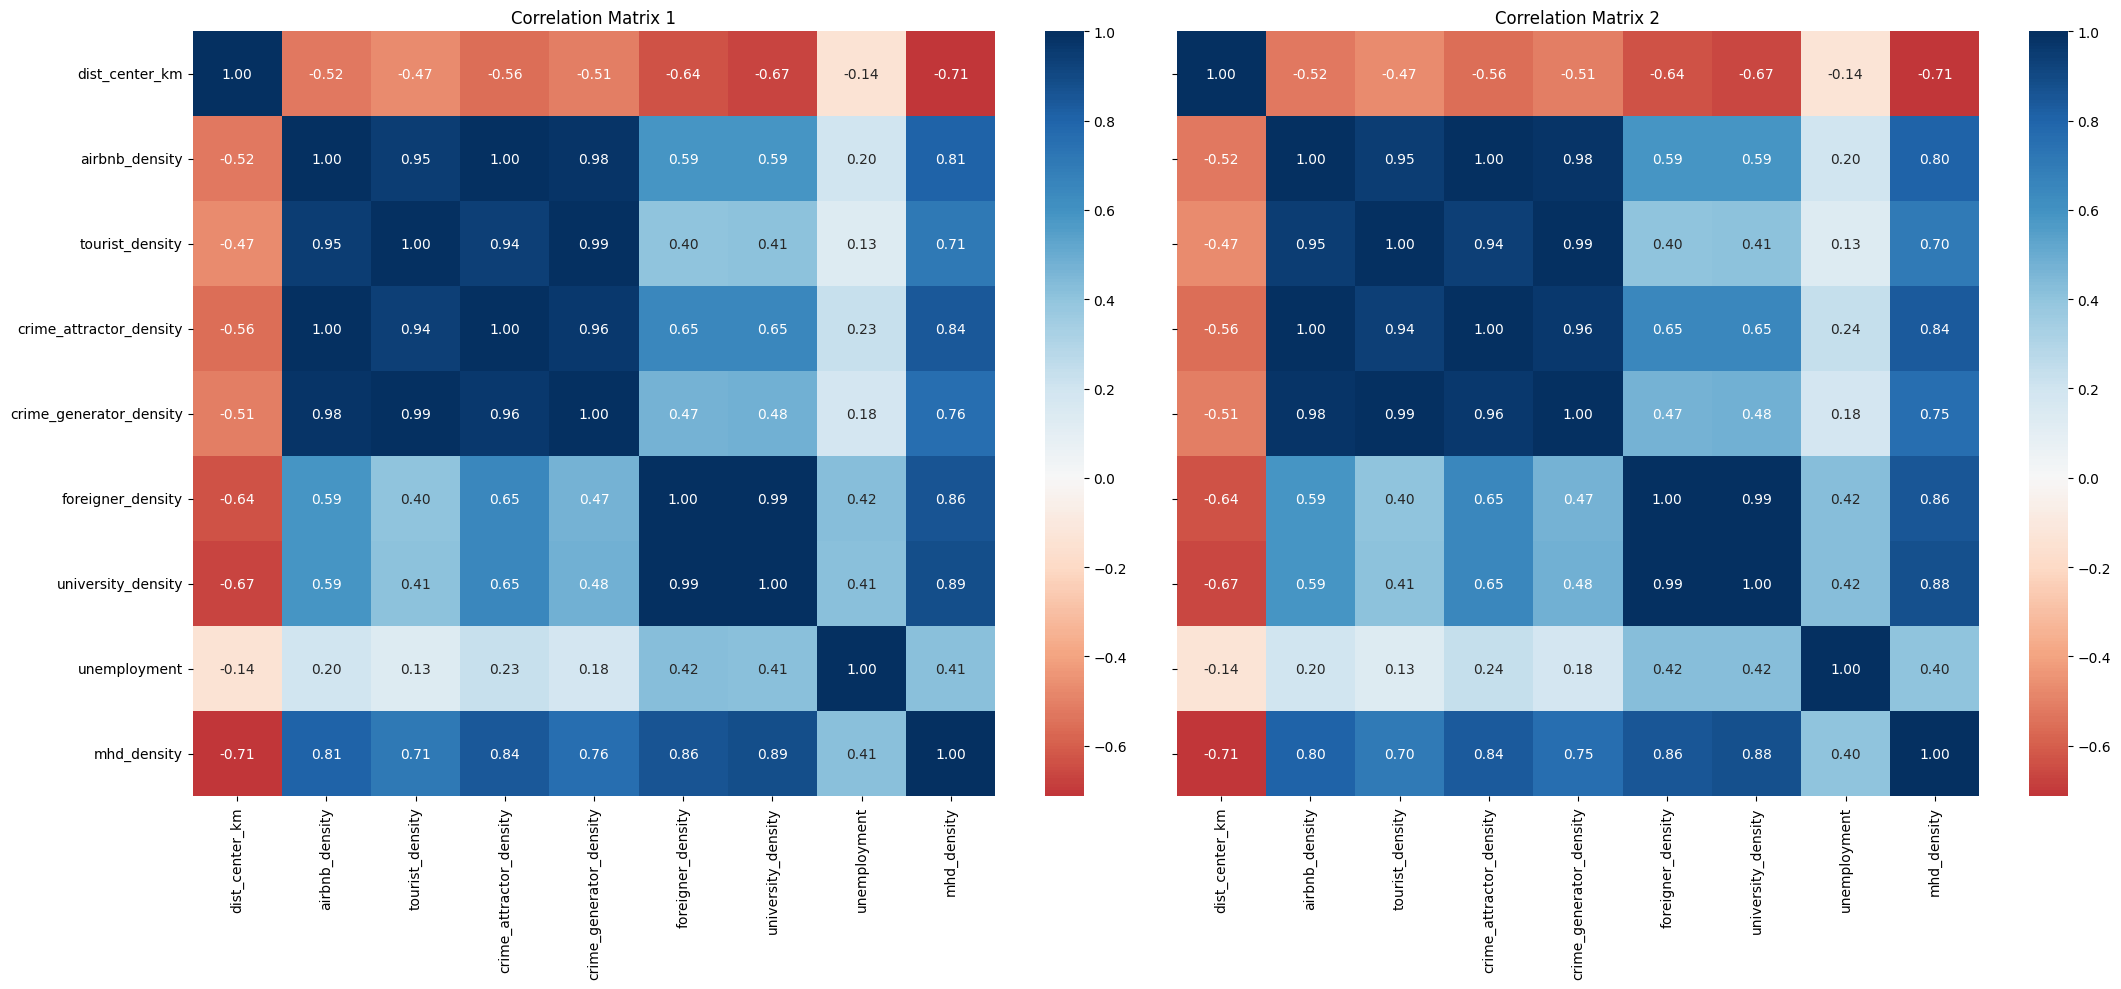

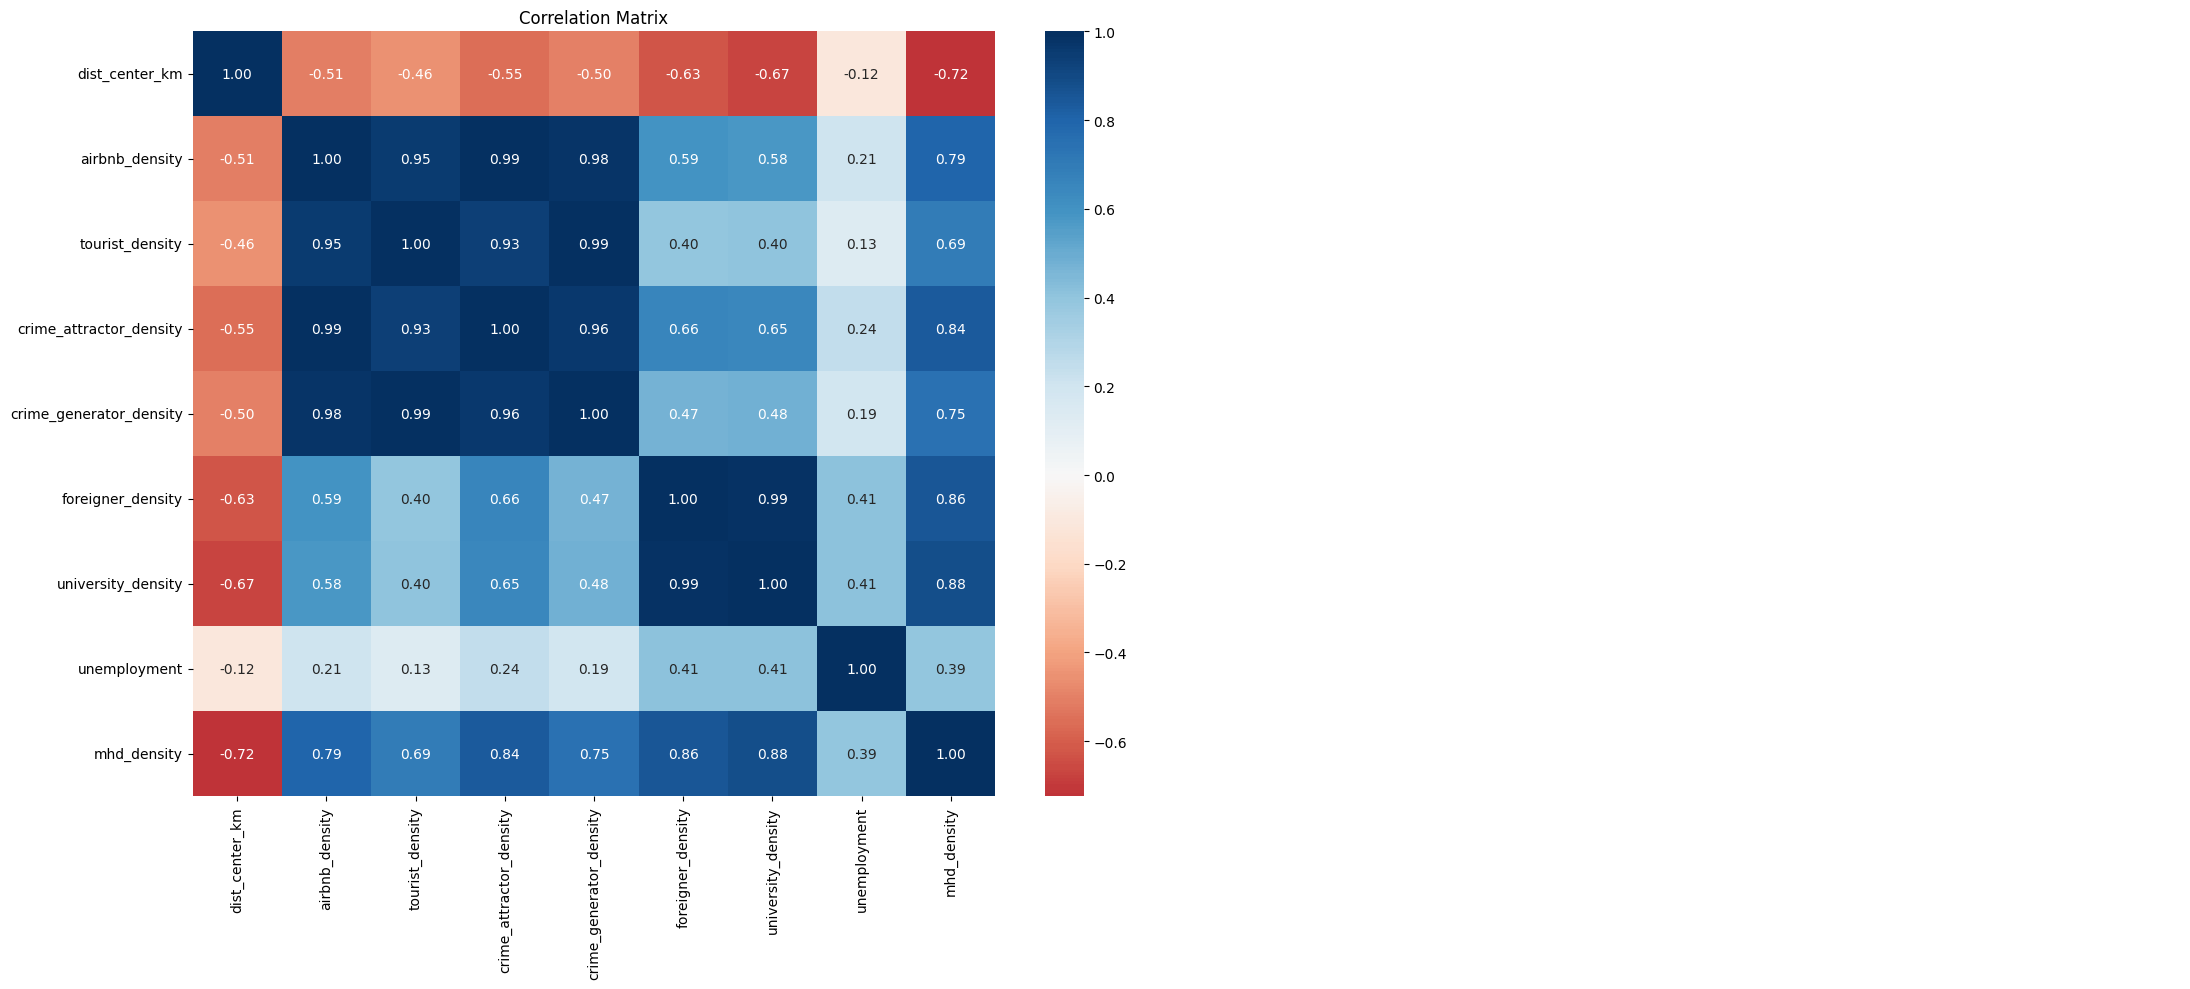

In [501]:
corr_mtx_double(corr_matrix_bulglary, corr_matrix_disorder)
corr_mtx_double(corr_matrix_theft, corr_matrix_violent)
corr_mtx_single(corr_matrix_other)

In [502]:
vif_data_bulglary = vif_calcul(X_bulglary, features)
vif_data_disorder = vif_calcul(X_disorder, features)
vif_data_theft = vif_calcul(X_theft, features)
vif_data_violent = vif_calcul(X_violent, features)
vif_data_other = vif_calcul(X_other, features)

In [503]:
print("\nBurglary Airbnb VIFs:\n")
print(vif_data_bulglary.sort_values(by="VIF", ascending=False))

print("\nDisorder Airbnb VIFs:\n")
print(vif_data_disorder.sort_values(by="VIF", ascending=False))

print("\nTheft Airbnb VIFs:\n")
print(vif_data_theft.sort_values(by="VIF", ascending=False))

print("\nViolent Airbnb VIFs:\n")
print(vif_data_violent.sort_values(by="VIF", ascending=False))

print("\nOther Airbnb VIFs:\n")
print(vif_data_other.sort_values(by="VIF", ascending=False))


Burglary Airbnb VIFs:

                   feature         VIF
3  crime_attractor_density  483.947539
1           airbnb_density  411.763230
4  crime_generator_density  199.511379
2          tourist_density   94.576662
6       university_density   81.507196
5        foreigner_density   60.905657
9                intercept   37.441813
8              mhd_density   15.560630
0           dist_center_km    2.453530
7             unemployment    1.630820

Disorder Airbnb VIFs:

                   feature         VIF
3  crime_attractor_density  374.106950
1           airbnb_density  332.324384
4  crime_generator_density  194.169340
2          tourist_density   90.357296
6       university_density   88.857662
5        foreigner_density   63.640328
9                intercept   37.622998
8              mhd_density   15.435959
0           dist_center_km    2.559178
7             unemployment    1.606559

Theft Airbnb VIFs:

                   feature         VIF
3  crime_attractor_density  483.49

In [504]:
_features = features.copy()
final_features_burglary, final_vif_table_burglary = stepwise_feature_selection(X_bulglary, _features)
print("\nFinal VIF table burglary:\n", final_vif_table_burglary)
print()

_features = features.copy()
final_features_disorder, final_vif_table_disorder = stepwise_feature_selection(X_disorder, _features)
print("\nFinal VIF table disorder:\n", final_vif_table_disorder)
print()

_features = features.copy()
final_features_theft, final_vif_table_theft = stepwise_feature_selection(X_theft, _features)
print("\nFinal VIF table theft:\n", final_vif_table_theft)
print()

_features = features.copy()
final_features_violent, final_vif_table_violent = stepwise_feature_selection(X_violent, _features)
print("\nFinal VIF table violent:\n", final_vif_table_violent)
print()

_features = features.copy()
final_features_other, final_vif_table_other = stepwise_feature_selection(X_other, _features)
print("\nFinal VIF table other:\n", final_vif_table_other)

Dropping crime_attractor_density with VIF 483.95
Dropping crime_generator_density with VIF 196.30
Dropping university_density with VIF 52.01
Dropping airbnb_density with VIF 25.56
Dropping mhd_density with VIF 11.04

Final VIF table burglary:
              feature       VIF
2  foreigner_density  2.067811
0     dist_center_km  1.867946
1    tourist_density  1.316510
3       unemployment  1.259888

Dropping crime_attractor_density with VIF 374.11
Dropping crime_generator_density with VIF 192.62
Dropping university_density with VIF 54.73
Dropping airbnb_density with VIF 24.93
Dropping mhd_density with VIF 10.26

Final VIF table disorder:
              feature       VIF
2  foreigner_density  2.111527
0     dist_center_km  1.892655
1    tourist_density  1.299304
3       unemployment  1.257000

Dropping crime_attractor_density with VIF 483.50
Dropping crime_generator_density with VIF 193.54
Dropping university_density with VIF 60.09
Dropping airbnb_density with VIF 24.78
Dropping mhd_density

#### Scale data

In [505]:
X_bulglary_scaled, y_bur = scale_data(X_bulglary, features)
X_disorder_scaled, y_dis = scale_data(X_disorder, features)
X_theft_scaled, y_the = scale_data(X_theft, features)
X_violent_scaled, y_vio = scale_data(X_violent, features)
X_other_scaled, y_oth = scale_data(X_other, features)

##### Ridge Regression

In [506]:
ridge_regression(X_bulglary_scaled, y_bur, features)
print()
ridge_regression(X_disorder_scaled, y_dis, features)
print()
ridge_regression(X_theft_scaled, y_the, features)
print()
ridge_regression(X_violent_scaled, y_vio, features)
print()
ridge_regression(X_other_scaled, y_oth, features)

Best Alpha for Ridge: 0.1
Ridge Coefficients:
 mhd_density                1.836953
crime_generator_density    0.954819
foreigner_density          0.954086
tourist_density            0.087429
unemployment              -0.138997
dist_center_km            -0.241566
airbnb_density            -0.568444
university_density        -0.861252
crime_attractor_density   -1.344102
dtype: float64

Best Alpha for Ridge: 0.1
Ridge Coefficients:
 mhd_density                1.802753
crime_generator_density    1.051195
foreigner_density          1.036833
tourist_density           -0.026902
unemployment              -0.138055
dist_center_km            -0.247488
airbnb_density            -0.361198
university_density        -0.947385
crime_attractor_density   -1.473316
dtype: float64

Best Alpha for Ridge: 0.1
Ridge Coefficients:
 mhd_density                1.665499
crime_generator_density    1.060515
foreigner_density          1.006051
tourist_density            0.082747
unemployment              -0.112907

#### Lasso regression

In [507]:
lasso_regression(X_bulglary_scaled, y_bur, features)
print()
lasso_regression(X_disorder_scaled, y_dis, features)
print()
lasso_regression(X_theft_scaled, y_the, features)
print()
lasso_regression(X_violent_scaled, y_vio, features)
print()
lasso_regression(X_other_scaled, y_oth, features)

Best Alpha for Lasso: 0.00278545249935906
Lasso Coefficients:
 mhd_density                1.812884
crime_generator_density    0.877822
foreigner_density          0.798027
tourist_density            0.079520
airbnb_density            -0.000000
unemployment              -0.125851
dist_center_km            -0.243360
university_density        -0.662148
crime_attractor_density   -1.841113
dtype: float64



/home/teruna/Documents/cvut_fel/engineer/san/_semestral_work/SAN/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1682: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
/home/teruna/Documents/cvut_fel/engineer/san/_semestral_work/SAN/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1682: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(


Best Alpha for Lasso: 0.003080402011833218
Lasso Coefficients:
 mhd_density                1.780806
crime_generator_density    0.908201
foreigner_density          0.838982
tourist_density            0.000000
airbnb_density            -0.000000
unemployment              -0.126386
dist_center_km            -0.246924
university_density        -0.731001
crime_attractor_density   -1.714442
dtype: float64

Best Alpha for Lasso: 0.0023017940905053287
Lasso Coefficients:
 mhd_density                1.639985
crime_generator_density    1.148157
foreigner_density          0.942611
tourist_density            0.000000
airbnb_density            -0.033344
unemployment              -0.105832
dist_center_km            -0.247696
university_density        -0.674205
crime_attractor_density   -1.908610
dtype: float64

Best Alpha for Lasso: 0.003495516613862387
Lasso Coefficients:
 mhd_density                1.771185
crime_generator_density    0.869654
foreigner_density          0.846827
tourist_density    

/home/teruna/Documents/cvut_fel/engineer/san/_semestral_work/SAN/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1682: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
/home/teruna/Documents/cvut_fel/engineer/san/_semestral_work/SAN/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1682: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
/home/teruna/Documents/cvut_fel/engineer/san/_semestral_work/SAN/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1682: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(


Best Alpha for Lasso: 0.0015244003223327176
Lasso Coefficients:
 mhd_density                1.884222
crime_generator_density    1.213492
foreigner_density          1.171019
tourist_density            0.000000
airbnb_density             0.000000
unemployment              -0.142126
dist_center_km            -0.221677
university_density        -0.998280
crime_attractor_density   -2.134784
dtype: float64


## Dimensionality Reduction and Clustering

#### Burglary

PC1 explains 68.41% of the variance.
PC2 explains 16.52% of the variance.
PC3 explains 9.37% of the variance.


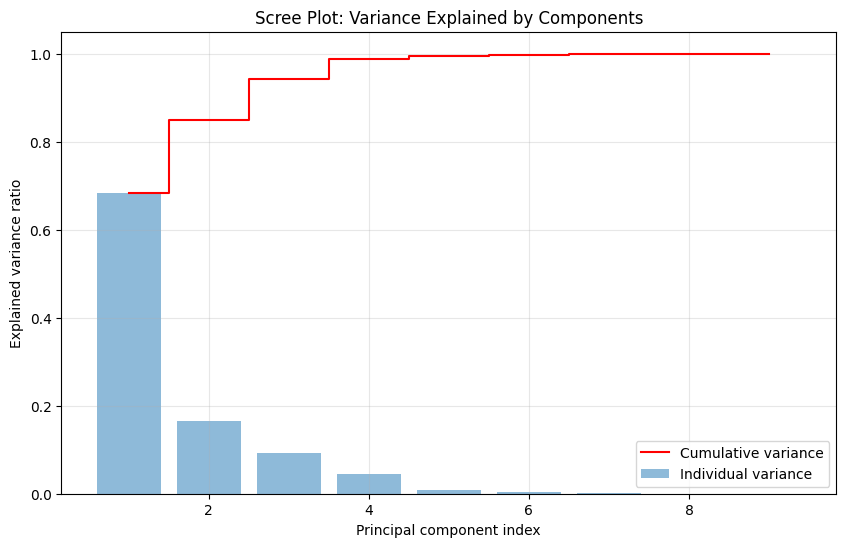

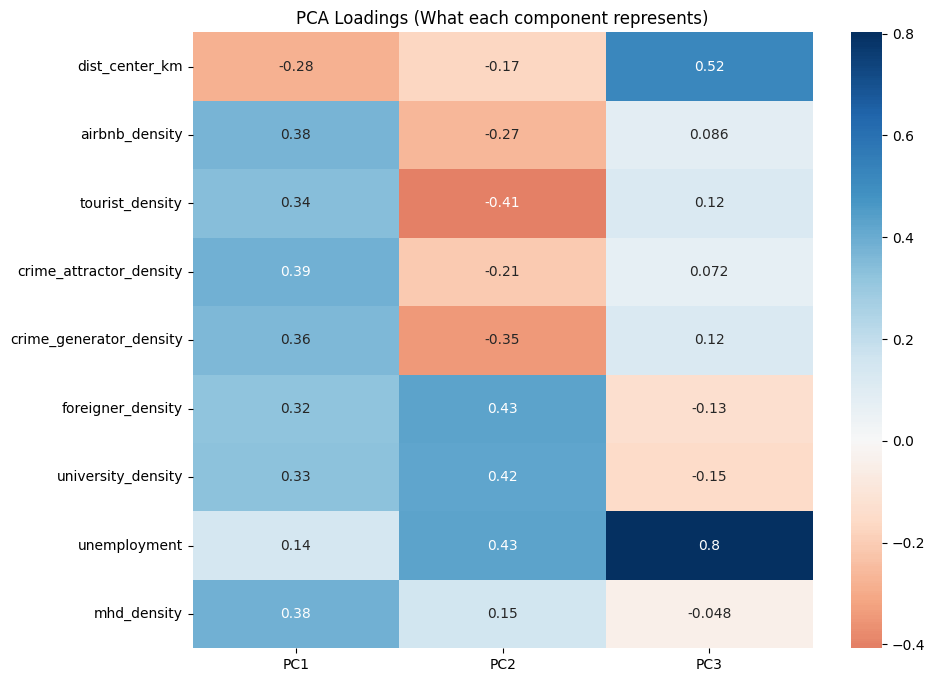

In [508]:
from sklearn.decomposition import PCA

pca = PCA()
pca_features = pca.fit_transform(X_bulglary_scaled)

scree_plot(pca)
pca_loadings(pca, features)

X_bulglary['urban_intensity_pc11'] = pca_features[:, 0]
X_bulglary['social_structure_pc2'] = pca_features[:, 1]

print(f"PC1 explains {pca.explained_variance_ratio_[0]:.2%} of the variance.")
print(f"PC2 explains {pca.explained_variance_ratio_[1]:.2%} of the variance.")
print(f"PC3 explains {pca.explained_variance_ratio_[2]:.2%} of the variance.")

#### Disorder

PC1 explains 67.95% of the variance.
PC2 explains 16.99% of the variance.
PC3 explains 9.39% of the variance.


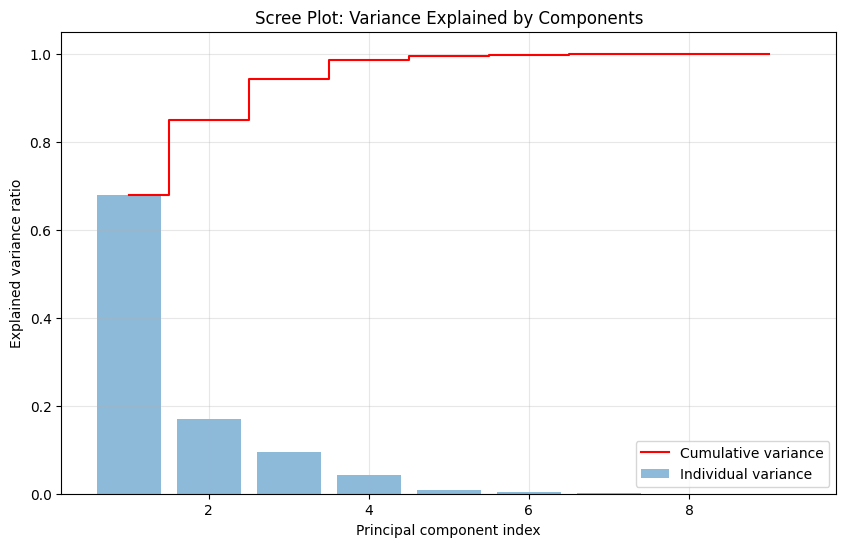

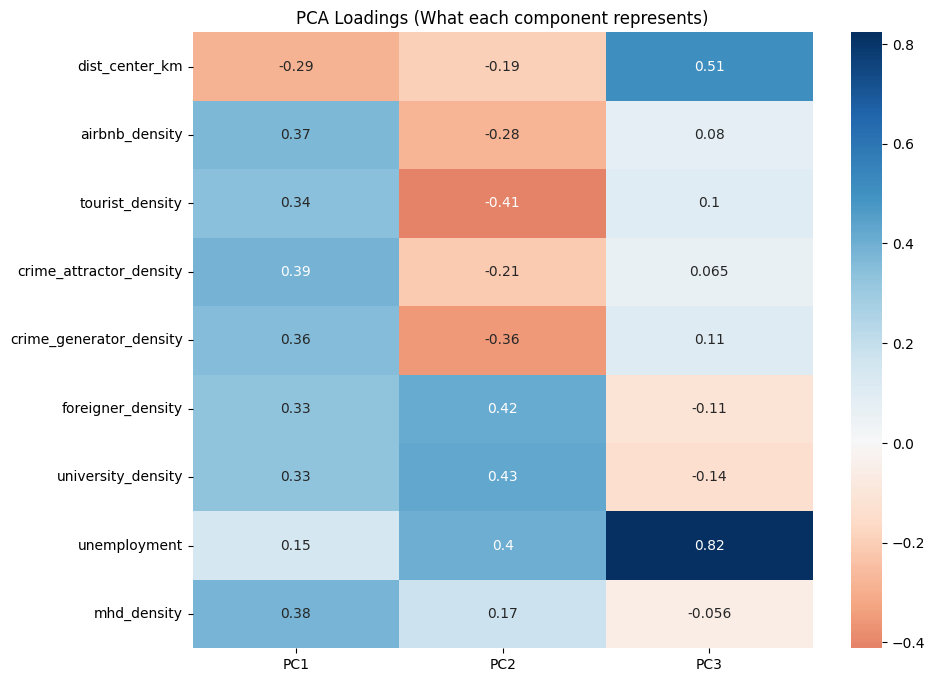

In [509]:
pca = PCA()
pca_features = pca.fit_transform(X_disorder_scaled)

scree_plot(pca)
pca_loadings(pca, features)

X_disorder['urban_intensity_pc11'] = pca_features[:, 0]
X_disorder['social_structure_pc2'] = pca_features[:, 1]

print(f"PC1 explains {pca.explained_variance_ratio_[0]:.2%} of the variance.")
print(f"PC2 explains {pca.explained_variance_ratio_[1]:.2%} of the variance.")
print(f"PC3 explains {pca.explained_variance_ratio_[2]:.2%} of the variance.")

#### Theft

PC1 explains 68.32% of the variance.
PC2 explains 16.92% of the variance.
PC3 explains 9.17% of the variance.


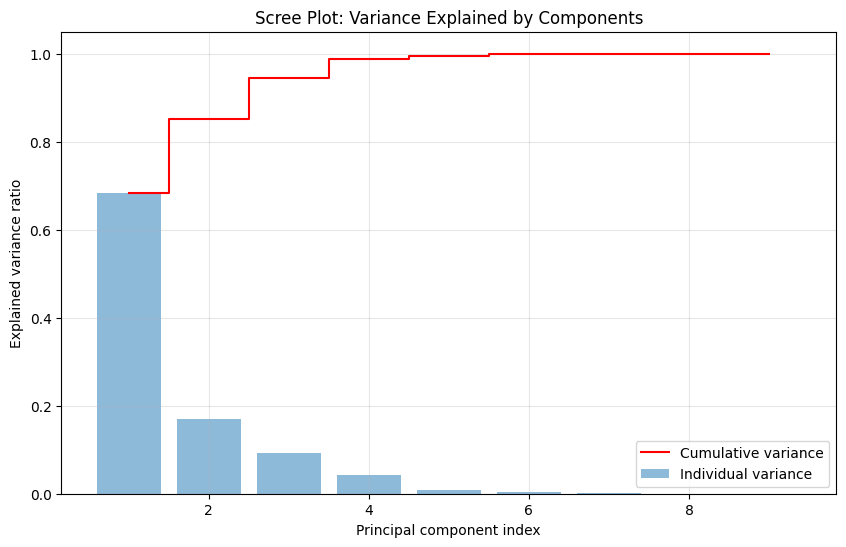

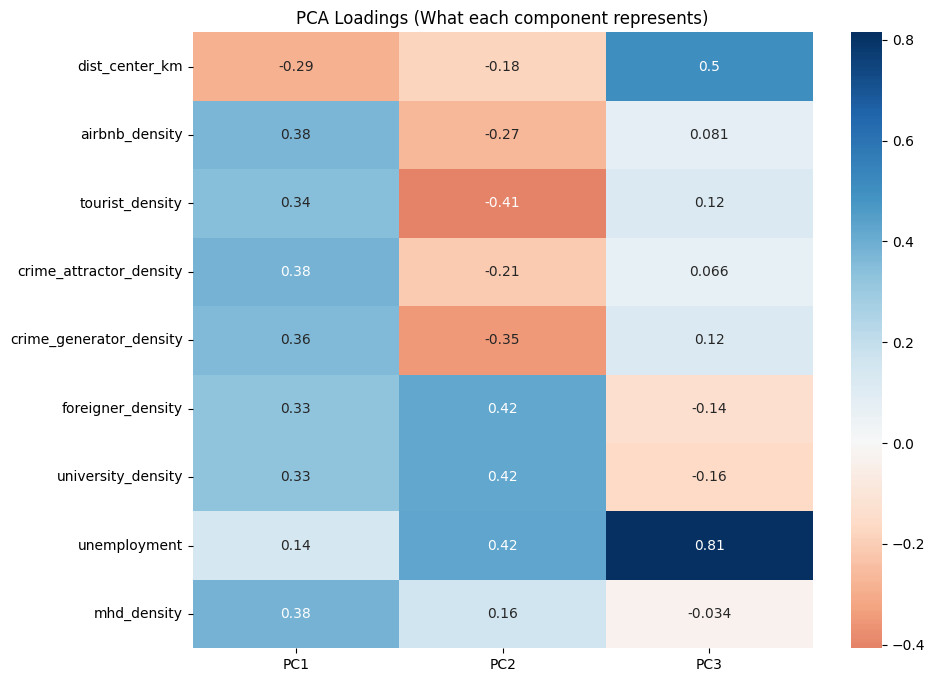

In [510]:
pca = PCA()
pca_features = pca.fit_transform(X_theft_scaled)

scree_plot(pca)
pca_loadings(pca, features)

X_theft['urban_intensity_pc11'] = pca_features[:, 0]
X_theft['social_structure_pc2'] = pca_features[:, 1]

print(f"PC1 explains {pca.explained_variance_ratio_[0]:.2%} of the variance.")
print(f"PC2 explains {pca.explained_variance_ratio_[1]:.2%} of the variance.")
print(f"PC3 explains {pca.explained_variance_ratio_[2]:.2%} of the variance.")

#### Violent

PC1 explains 68.24% of the variance.
PC2 explains 16.86% of the variance.
PC3 explains 9.22% of the variance.


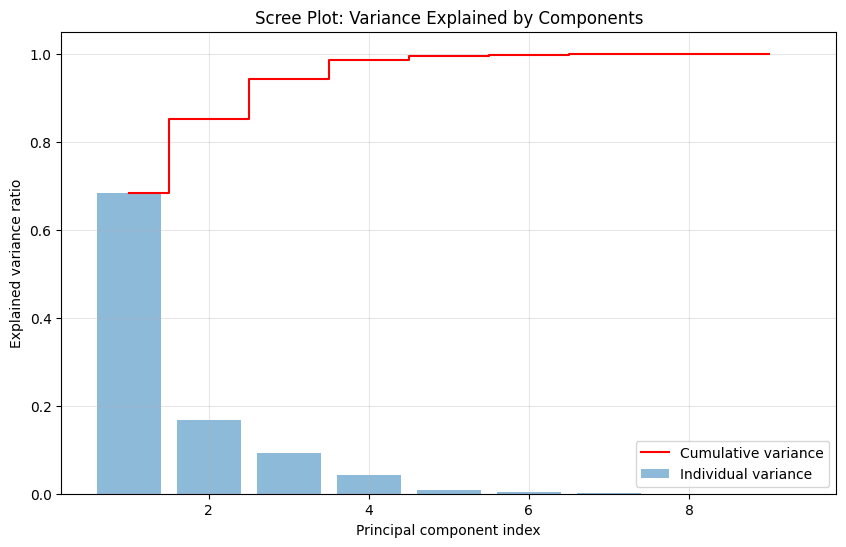

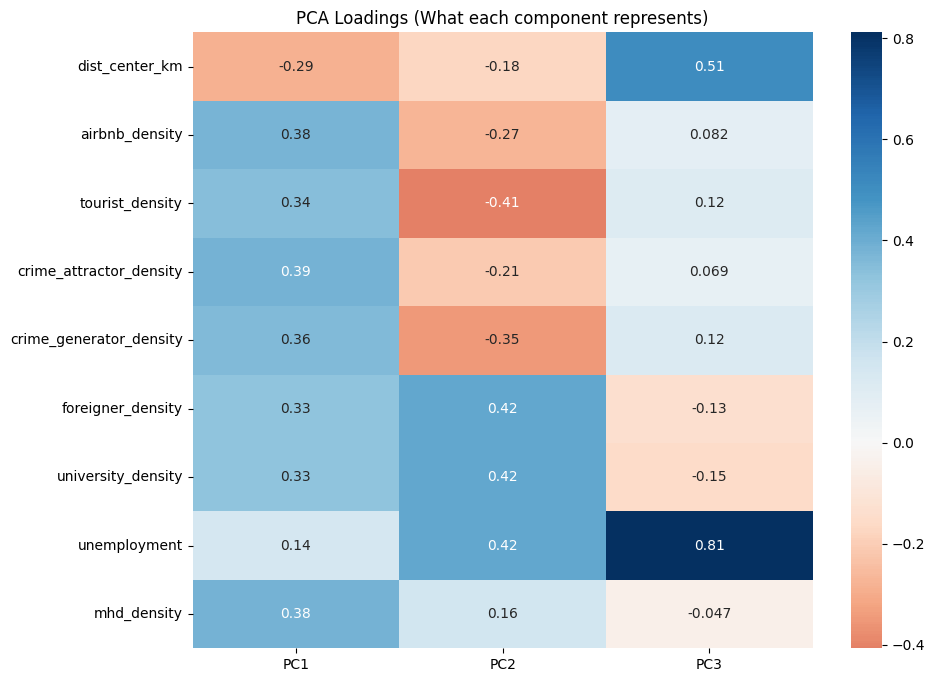

In [511]:
pca = PCA()
pca_features = pca.fit_transform(X_violent_scaled)

scree_plot(pca)
pca_loadings(pca, features)

X_violent['urban_intensity_pc11'] = pca_features[:, 0]
X_violent['social_structure_pc2'] = pca_features[:, 1]

print(f"PC1 explains {pca.explained_variance_ratio_[0]:.2%} of the variance.")
print(f"PC2 explains {pca.explained_variance_ratio_[1]:.2%} of the variance.")
print(f"PC3 explains {pca.explained_variance_ratio_[2]:.2%} of the variance.")

#### Other

PC1 explains 68.08% of the variance.
PC2 explains 16.80% of the variance.
PC3 explains 9.53% of the variance.


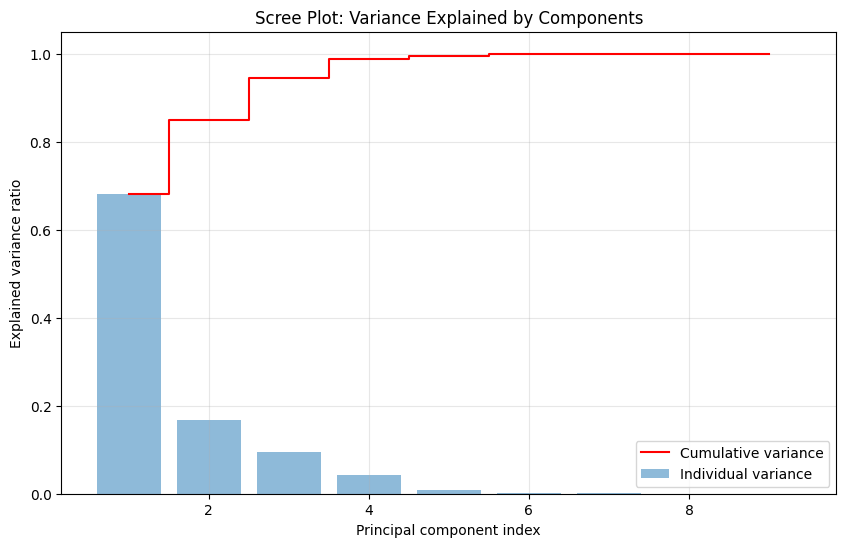

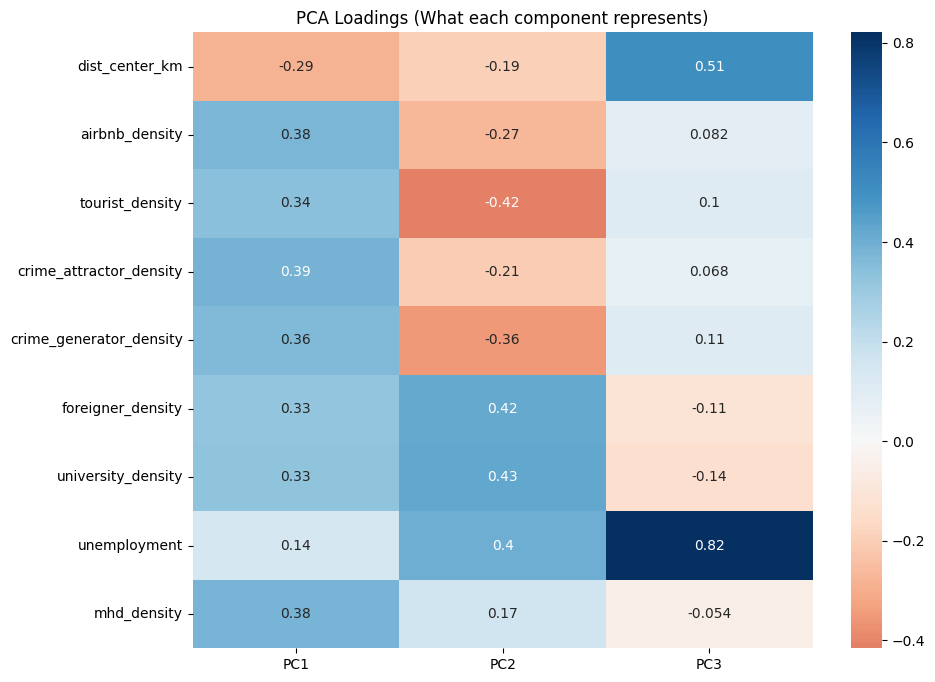

In [512]:
pca = PCA()
pca_features = pca.fit_transform(X_other_scaled)

scree_plot(pca)
pca_loadings(pca, features)

X_other['urban_intensity_pc11'] = pca_features[:, 0]
X_other['social_structure_pc2'] = pca_features[:, 1]

print(f"PC1 explains {pca.explained_variance_ratio_[0]:.2%} of the variance.")
print(f"PC2 explains {pca.explained_variance_ratio_[1]:.2%} of the variance.")
print(f"PC3 explains {pca.explained_variance_ratio_[2]:.2%} of the variance.")